In [1]:
# General
# File system management
import os

# Visualisation
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns

import math
from termcolor import colored
import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 

import pickle
from urllib.parse import urlparse

import mlflow
import mlflow.sklearn
import mlflow.pyfunc

# Format & option
sns.set(rc={"figure.figsize": (16, 9)})
pd.options.display.max_columns = 150

# Style use
sns.set_style("darkgrid")
plt.style.use("ggplot")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
%matplotlib inline

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

#import shap

%matplotlib inline

!pip install ipython-autotime

In [3]:
!mlflow ui

^C


In [2]:
mlflow.set_tracking_uri("http://127.0.0.1:4004")
mlflow.set_experiment('Modèles')

<Experiment: artifact_location='mlflow-artifacts:/397281261634535360', creation_time=1696348457728, experiment_id='397281261634535360', last_update_time=1696348457728, lifecycle_stage='active', name='Modèles', tags={}>

In [3]:
def classification(best_params, X_train, y_train, X_test, y_test, algo_name, file_name=None):

    print(colored("Exécution \n ", 'red'))

    start_time = time.time()

    model = best_params.fit(X_train, y_train)

    execution_time = (time.time() - start_time)

    if file_name is None:
        pass
    else:
        filename = file_name
        pickle.dump(model, open(filename, 'wb'))

    start_time = time.time()

    prediction = best_params.predict(X_test)

    prediction_time = (time.time() - start_time)

    probability = best_params.predict_proba(X_test)
    probability_positive = probability[:, 1]

    resume_prediction_class = pd.DataFrame({'cat_reel': y_test, 'cat_predit': prediction}).reset_index()
    probability_positive_class = pd.DataFrame({'SK_ID_CURR': X_test.index, 'positive_probability': probability_positive})

    print(probability_positive_class)
    print(colored("Qualité de la classification \n \n ", 'red'))

    accuracy = accuracy_score(y_test, prediction)
    print(colored(f'L\'accuracy score est de {accuracy} pour la méthode {algo_name}.\n \n ', 'blue'))

    precision = precision_score(y_test, prediction, average='binary')
    print(colored(f'Le score de précision est de {precision} pour la méthode {algo_name}.\n \n ', 'blue'))

    recall = recall_score(y_test, prediction, average='binary')
    print(colored(f'Le score recall est de {recall} pour la méthode {algo_name}.\n \n ', 'blue'))

    f1 = f1_score(y_test, prediction, average='binary')
    print(colored(f'Le score f1 est de {f1} pour la méthode {algo_name}.\n \n ', 'blue'))

    AUC = roc_auc_score(y_test, probability[:, 1])  
    print(colored(f'Le score AUC est de {AUC} pour la méthode {algo_name}.\n \n ', 'blue'))

    with mlflow.start_run(run_name='Classification/' + algo_name) as run:
        mlflow.log_metric('accuracy', accuracy)
        mlflow.log_metric('precision', precision)
        mlflow.log_metric('recall', recall)
        mlflow.log_metric('f1', f1)
        mlflow.log_metric('AUC', AUC)
        mlflow.log_metric('execution_time', execution_time)
        mlflow.log_metric('prediction_time', prediction_time)

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(model, algo_name, registered_model_name="CreditModels")
        else:
            mlflow.sklearn.log_model(model, algo_name)
            
    return model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class

In [4]:
def matrix_TN_FN(y_test, y_prediction):

    # Création de la matrice de confusion
    df_matrice_confusion = pd.DataFrame(columns=['Predicted Negative (0)', 'Predicted Positive (1)'],
                                        index=['Real Negative (0)', 'Real Positive (1)'])

    # Création d'un DataFrame de comparaison avec les valeurs réelles et les valeurs prédites côte à côte.
    df_pred_compare = pd.concat([pd.Series(y_test.reset_index(drop=True)), pd.Series(y_prediction)], axis=1)
    df_pred_compare.columns = ['Real category', 'Prediction']

    # Masque pour les vrais positifs, les vrais négatifs, les faux positifs et les faux négatifs.
    mask_real_pos = (df_pred_compare['Real category'] == 1)
    mask_pred_pos = (df_pred_compare['Prediction'] == 1)
    mask_real_neg = (df_pred_compare['Real category'] == 0)
    mask_pred_neg = (df_pred_compare['Prediction'] == 0)

    # Calcul du nombre de vrais négatifs (TN) et de faux négatifs (FN).
    true_negative = df_pred_compare[mask_real_neg & mask_pred_neg].shape[0]
    false_negative = df_pred_compare[mask_real_pos & mask_pred_neg].shape[0]

    # Calcul du nombre de faux positifs (FP) et de vrais positifs (TP).
    false_positive = df_pred_compare[mask_real_neg & mask_pred_pos].shape[0]
    true_positive = df_pred_compare[mask_real_pos & mask_pred_pos].shape[0]

    # Remplissage de la matrice de confusion avec les valeurs calculées.
    df_matrice_confusion['Predicted Negative (0)'] = [f"{true_negative} (TN)", f"{false_negative} (FN)"]
    df_matrice_confusion['Predicted Positive (1)'] = [f"{false_positive} (FP)", f"{true_positive} (TP)"]

    return df_matrice_confusion

def cf_matrix_roc_auc(y_true, y_pred, y_pred_proba, size):

    # Crée une nouvelle figure avec la taille spécifiée.
    fig = plt.figure(figsize=size)

    # Ajoute un subplot pour la matrice de confusion.
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Confusion Matrix')

    # Calcule la matrice de confusion.
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Récupère les valeurs TN, FP, FN et TP à partir de la matrice de confusion.
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    # Noms des groupes pour les annotations.    
    group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']

    # Formate les valeurs pour les annotations.
    group_counts = [f"{value :0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    # Prépare les annotations avec les noms, les comptes et les pourcentages.
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Crée une heatmap avec les annotations.
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='RdPu')

    # Paramètres d'affichage pour l'axe des x.
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)

    # Ajoute un subplot pour la courbe ROC.
    ax2 = fig.add_subplot(222)
    ax2.title.set_text('ROC Curve')

    # Calcule les taux de faux positifs et de vrais positifs pour la courbe ROC.
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])  # Pour la courbe ROC, utilisation de la probabilité d'être 1.

    # Trace la courbe ROC avec l'aire sous la courbe (AUC).
    plt.plot(fpr, tpr, color='pink', linewidth=5, label='AUC = %0.4f' % roc_auc)
    
    # Trace la droite en pointillés (ligne de référence).
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # Affiche la figure avec la matrice de confusion et la courbe ROC.
    plt.show()

    # Affiche les valeurs TN, FP, FN et TP.
    print('True negative = ', tn)
    print('False positive = ', fp)
    print('False negative = ', fn)
    print('True positive = ', tp)

    # Renvoie les valeurs TN, FP, FN et TP.
    return tn, fp, fn, tp

In [11]:
def cf_matrix_roc_auc(y_true, y_pred, y_pred_proba, size, save_path):

    # Crée une nouvelle figure avec la taille spécifiée.
    fig = plt.figure(figsize=size)

    # Ajoute un subplot pour la matrice de confusion.
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Confusion Matrix')

    # Calcule la matrice de confusion.
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Récupère les valeurs TN, FP, FN et TP à partir de la matrice de confusion.
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    # Noms des groupes pour les annotations.    
    group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']

    # Formate les valeurs pour les annotations.
    group_counts = [f"{value :0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    # Prépare les annotations avec les noms, les comptes et les pourcentages.
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Crée une heatmap avec les annotations.
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='RdPu')

    # Paramètres d'affichage pour l'axe des x.
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)

    # Ajoute un subplot pour la courbe ROC.
    ax2 = fig.add_subplot(222)
    ax2.title.set_text('ROC Curve')

    # Calcule les taux de faux positifs et de vrais positifs pour la courbe ROC.
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])  # Pour la courbe ROC, utilisation de la probabilité d'être 1.

    # Trace la courbe ROC avec l'aire sous la courbe (AUC).
    plt.plot(fpr, tpr, color='pink', linewidth=5, label='AUC = %0.4f' % roc_auc)
    
    # Trace la droite en pointillés (ligne de référence).
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    plt.savefig(save_path)

    
    # Affiche la figure avec la matrice de confusion et la courbe ROC.
    plt.show()

    # Affiche les valeurs TN, FP, FN et TP.
    print('True negative = ', tn)
    print('False positive = ', fp)
    print('False negative = ', fn)
    print('True positive = ', tp)


    # Renvoie les valeurs TN, FP, FN et TP.
    return tn, fp, fn, tp


In [6]:
def score_banq(tn, fp, fn, tp, coeff_tn, coeff_fp, coeff_fn, coeff_tp):

    total = (coeff_tn*tn + coeff_fp*fp + coeff_fn*fn + coeff_tp*tp)

    #calcul du gain maximal que peut avoir la banque quand il n'y a pas de perte d'argent. C'est à dire que le modèle ne détecte que TN et les TP.
    max_gain = (tn + fp)*coeff_tn + (tp + fn)*coeff_tp

    #calcul du gain minimal (perte) que peut avoir la banque quand il n'y a pas de gain d'argent. C'est à dire que le modèle ne détecte que FN et les FP.
    min_gain = (tn + fp)*coeff_fp + (tp + fn)*coeff_fn

    #normalisation min-max feature scalling : score= (tot-min)/(max-min) https://en.wikipedia.org/wiki/Normalization_(statistics) 
    score = (total - min_gain)/(max_gain - min_gain)

    return score

In [7]:
# import fichier df_train_imputed sans la standardisation
df_train = pd.read_csv('df_train.csv', index_col='SK_ID_CURR', encoding ='utf-8')

import re
# supprimant tout caractère spécial autre que les lettres, les chiffres et le caractère souligné ('_'). 
df_train = df_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [8]:
df_train

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,...,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business_Entity_Type_1,ORGANIZATION_TYPE_Business_Entity_Type_2,ORGANIZATION_TYPE_Business_Entity_Type_3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry_type_1,ORGANIZATION_TYPE_Industry_type_10,ORGANIZATION_TYPE_Industry_type_11,ORGANIZATION_TYPE_Industry_type_12,ORGANIZATION_TYPE_Industry_type_13,ORGANIZATION_TYPE_Industry_type_2,ORGANIZATION_TYPE_Industry_type_3,ORGANIZATION_TYPE_Industry_type_4,ORGANIZATION_TYPE_Industry_type_5,ORGANIZATION_TYPE_Industry_type_6,ORGANIZATION_TYPE_Industry_type_7,ORGANIZATION_TYPE_Industry_type_9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal_Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security_Ministries,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade_type_1,ORGANIZATION_TYPE_Trade_type_2,ORGANIZATION_TYPE_Trade_type_3,ORGANIZATION_TYPE_Trade_type_4,ORGANIZATION_TYPE_Trade_type_5,ORGANIZATION_TYPE_Trade_type_6,ORGANIZATION_TYPE_Trade_type_7,ORGANIZATION_TYPE_Transport_type_1,ORGANIZATION_TYPE_Transport_type_2,ORGANIZATION_TYPE_Transport_type_3,ORGANIZATION_TYPE_Transport_type_4,ORGANIZATION_TYPE_University,HOUSETYPE_MODE_block_of_flats,HOUSETYPE_MODE_specific_housing,HOUSETYPE_MODE_terraced_house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stone_brick,WALLSMATERIAL_MODE_Wooden,MOST_CREDIT_TYPE_Another_type_of_loan,MOST_CREDIT_TYPE_Car_loan,MOST_CREDIT_TYPE_Consumer_credit,MOST_CREDIT_TYPE_Credit_card,MOST_CREDIT_TYPE_Loan_for_business_development,MOST_CREDIT_TYPE_Loan_for_working_capital_replenishment,MOST_CREDIT_TYPE_Microloan,MOST_CREDIT_TYPE_Mortgage,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0,1,0,1,0,-0.573222,0.069058,-0.513860,-0.222911,-0.544493,-0.226831,-1.521797,0.784979,0.435145,0.592401,0.002542,0.458151,-0.46321,0.047807,1.490005,-0.267116,-1.234433,0.032789,0.100683,-0.691452,-0.1

In [9]:
X = df_train.copy()
y = X['TARGET']
X = X.drop(['TARGET'], axis=1)
X = X[X.columns]

# Split en training/testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2  # 20% des données dans le jeu de test = 20% de short data
                                                    , random_state=42)

In [10]:
# afficher les dimenssions 
print("données d'entrainement :", X_train.shape)
print("données d'entrainement target :", y_train.shape)
print("données de test :", X_test.shape)
print("données de test target :", y_test.shape)

données d'entrainement : (123845, 209)
données d'entrainement target : (123845,)
données de test : (30962, 209)
données de test target : (30962,)


### Choix des modèles

### Gestion du déséquilibre des données

Nous allons procéder par 3 méthodes :

- Méthode du "Undersampling" : supprimer des observations de la classe majoritaire afin de rééquilibrer le jeu de données
- Méthode du "Oversampling" : répéter des observations de la classe minoritaire afin de rééquilibrer le jeu de données
- Méthode du "Weight_balanced" : indiquer au modèle le déséquilibre afin qu'il en tienne compte directement

Nous choisirons ensuite la méthode adaptée pour ce projet.

Pour la modélisation, 3 modèles seront choisis selon leurs performances:

Régression Logistique
RandomForestClassifier
LGBMClassifier

La performance sera évaluée grâce à une validation croisée pour pouvoir optimiser les hyperparamètres. 
Nous choisirons ensuite 2 métriques dévaluation: 
- le ROC AUC
    
    L'aire sous la courbe ROC (ou Area Under the Curve, AUC) peut être interprétée comme la probabilité que, parmi deux clients choisis au hasard, un bon et un mauvais, la valeur du marqueur soit plus élevée pour le bon que pour le mauvais.


- le F-beta score pour la  métrique métier: 
    
    F1 score: Dans l' analyse statistique de la classification binaire , le score F1 ou la mesure F1 est une mesure de la précision d'un test . Il est calculé à partir de la précision et du rappel du test, où la précision est le nombre de vrais résultats positifs divisé par le nombre de tous les résultats positifs, y compris ceux qui ne sont pas identifiés correctement, et le rappel est le nombre de vrais résultats positifs divisé par le nombre de tous les échantillons qui auraient dû être identifiés comme positifs. La précision est également connue sous le nom de valeur prédictive positive et le rappel est également connu sous le nom de sensibilité dans la classification binaire diagnostique
    
    F-beta score: Le score F1 est la moyenne harmonique de la précision et du rappel. Le plus générique F-beta score applique des pondérations supplémentaires, valorisant l'une de la précision ou du rappel plus que l'autre.



#### Choix des modèles 

#### Cross-validation

#### Régression logistique

In [24]:
# hyperparamètres à tester
param_grid = {"C":[-0.001, -0.01, -0.1, 1, 0.1, 0.01, 0.001, 5, 10, 15, 50, 100],
             'penalty': ['l1', 'l2']} 
        
score = 'roc_auc'

#Définition du modèle
model = LogisticRegression(random_state=42)

# grid search
lr= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV
lr.fit(X_train, y_train)

print("Le meilleur hyperparamètre sur le jeu d'entraînement est:")
best_params = lr.best_params_
print(best_params)
print(' ')
print("Le meilleur(s) score sur le jeu d'entraînement basé sur le 'roc_auc' est:")
print(lr.best_score_)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Le meilleur hyperparamètre sur le jeu d'entraînement est:
{'C': 0.1, 'penalty': 'l2'}
 
Le meilleur(s) score sur le jeu d'entraînement basé sur le 'roc_auc' est:
0.7369849042035739


#### LGBM

In [28]:
param_grid = {
        'n_estimators' : np.arange(500, 1500, 100),
        'learning_rate' : [1, 0.1, 0.01, 0.001]
        }

score = 'roc_auc'


model = LGBMClassifier(objective='binary', random_state=42)

lgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

lgbm.fit(X_train, y_train, eval_metric='auc')

print("Les meilleurs hyperparamètres sont:")
best_params = lgbm.best_params_
print(best_params)
print(' ')
print("Le meilleur score 'roc_auc' est:")
print(lgbm.best_score_)

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[LightGBM] [Info] Number of positive: 8654, number of negative: 115191
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10893
[LightGBM] [Info] Number of data points in the train set: 123845, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069878 -> initscore=-2.588570
[LightGBM] [Info] Start training from score -2.588570
Les meilleurs hyperparamètres sont:
{'learning_rate': 0.01, 'n_estimators': 1300}
 
Le meilleur score 'roc_auc' est:
0.7520963796458405


#### RandomForest Classifier

In [70]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42)

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10]
}

rf_cv = GridSearchCV(
    rf,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

rf_cv.fit(X_train, y_train)

print("Les meilleurs hyperparamètres sur le jeu d'entraînement sont :")
best_params = rf_cv.best_params_
print(best_params)
print(' ')
print("Le meilleur score 'roc_auc' est:")
print(rf_cv.best_score_)

Les meilleurs hyperparamètres sur le jeu d'entraînement sont :
{'max_depth': 10, 'n_estimators': 200}
 
Le meilleur score 'roc_auc' est:
0.7260093901557942


In [79]:
rf_cw = RandomForestClassifier(random_state = 42, 
                                     class_weight="balanced")

rf_cw_cv = GridSearchCV(
    rf_cw,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

rf_cw_cv.fit(X_train, y_train)

print("Les meilleurs hyperparamètres sur le jeu d'entraînement sont :")
best_params = rf_cw_cv.best_params_
print(best_params)
print(' ')
print("Le meilleur score 'roc_auc' est:")
print(rf_cw_cv.best_score_)

Les meilleurs hyperparamètres sur le jeu d'entraînement sont :
{'max_depth': 10, 'n_estimators': 200}
 
Le meilleur score 'roc_auc' est:
0.7212540648802162


#### régression logistique

In [12]:
# Définition des hyperparamètres 
best_params = LogisticRegression(
    C=0.1,  # Paramètre de régularisation inverse (plus petit est C, plus forte est la régularisation)
    penalty= 'l2')

In [13]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(best_params, X_train, y_train, X_test, y_test, "Régression logistique basal", file_name=None)


Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.036001
1          399406              0.035684
2          168652              0.097011
3          317387              0.021626
4          371921              0.156237
...           ...                   ...
30957      268716              0.059123
30958      398091              0.016441
30959      228535              0.031475
30960      107632              0.044540
30961      343857              0.131856

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.9313997803759447 pour la méthode Régression logistique basal.
 
 
Le score de précision est de 0.59375 pour la méthode Régression logistique basal.
 
 
Le score recall est de 0.00892018779342723 pour la méthode Régression logistique basal.
 
 
Le score f1 est de 0.01757631822386679 pour la méthode Régression logistique basal.
 
 
Le score AUC est de 0.7432079575119976 pour la méthode Régression logistique basal.
 
 


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/15 14:42:49 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 79
Created version '79' of model 'CreditModels'.


In [14]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
prediction = best_params.predict(X_test)
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),28819 (TN),13 (FP)
Real Positive (1),2111 (FN),19 (TP)


In [15]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
probability = best_params.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Résumé :')
print(classification_report(y_test, prediction))

AUC : 0.7432
Résumé :
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     28832
         1.0       0.59      0.01      0.02      2130

    accuracy                           0.93     30962
   macro avg       0.76      0.50      0.49     30962
weighted avg       0.91      0.93      0.90     30962



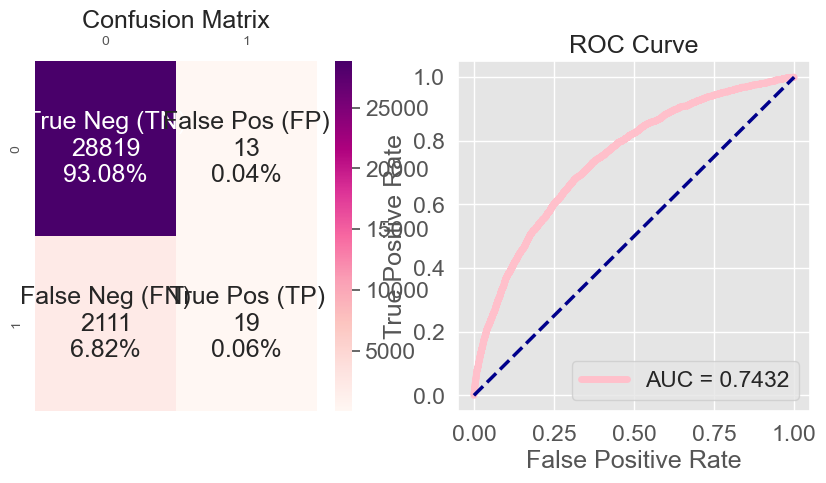

True negative =  28819
False positive =  13
False negative =  2111
True positive =  19


In [16]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (10, 10), "matrice_roc_RL.png")

In [17]:
mlflow.log_artifact("matrice_roc_RL.png")

In [18]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6015425764686354

In [19]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
start_time = time.time()

accuracy = accuracy_score(y_test, prediction)
AUC = roc_auc_score(y_test, probability[:, 1])  # probabilité de ne pas rembourser le prêt donc d'être étiqueté comme 1
recall = recall_score(y_test, prediction, average='binary')
f1 = f1_score(y_test, prediction, average='binary')
precision = precision_score(y_test, prediction, average='binary')
prediction_time = (time.time() - start_time)

comparison_baseline = pd.DataFrame(
        {
            "Modele": "Régression logistique basal",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[0],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_baseline

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Régression logistique basal,0.9314,0.743208,0.00892,0.017576,19,0.59375,2111,0.601543,0.061767


#### LGBM

In [22]:
# Vérifiez si un run MLflow est actif
if mlflow.active_run():
    # Si un run est actif, terminez-le
    mlflow.end_run()

In [23]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_params = LGBMClassifier(
    learning_rate= 0.01, n_estimators= 1300)
 

In [24]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train, y_train, X_test, y_test, "LGBMClassifier basal", file_name=None)

Exécution 
 
[LightGBM] [Info] Number of positive: 8654, number of negative: 115191
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10893
[LightGBM] [Info] Number of data points in the train set: 123845, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069878 -> initscore=-2.588570
[LightGBM] [Info] Start training from score -2.588570
       SK_ID_CURR  positive_probability
0          316145              0.049604
1          399406              0.036067
2          168652              0.105210
3          317387              0.052361
4          371921              0.202232
...           ...                   ...
30957      268716              0.055854
30958      398091              0.029552
30959      228535              0.035952
30960      107632              0.043063
30961      343857              0.120943

[30962

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/15 14:45:10 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 80
Created version '80' of model 'CreditModels'.


In [25]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),28811 (TN),21 (FP)
Real Positive (1),2110 (FN),20 (TP)


In [26]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Résumé :')
print(classification_report(y_test, prediction))

AUC : 0.7605
Résumé :
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     28832
         1.0       0.49      0.01      0.02      2130

    accuracy                           0.93     30962
   macro avg       0.71      0.50      0.49     30962
weighted avg       0.90      0.93      0.90     30962



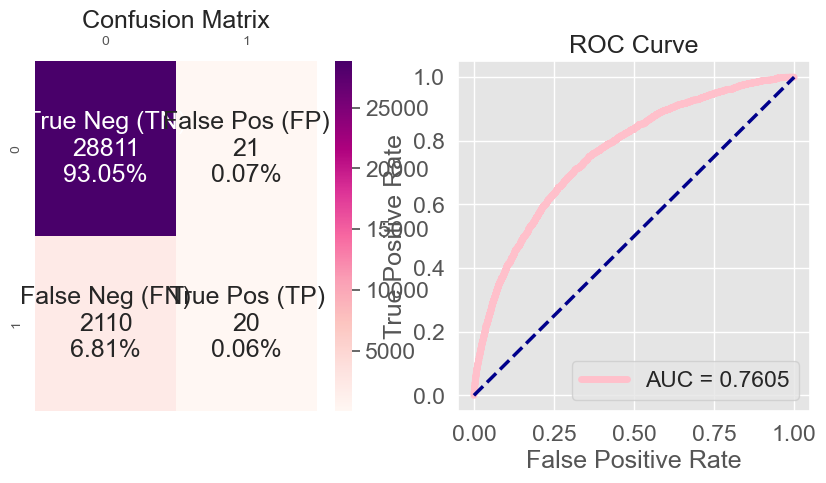

True negative =  28811
False positive =  21
False negative =  2110
True positive =  20


In [27]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (10, 10), "matrice_roc_LGBM.png")

In [28]:
mlflow.log_artifact("matrice_roc_LGBM.png")

In [29]:
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6015652114865171

In [30]:
# Ajout des métriques du modèle LGBMClassifier à la DataFrame comparison_baseline
comparison_baseline_lgbm = pd.DataFrame(
        {
            "Modele": "LGBMClassifier basal",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[1],                          # Utilisation de l'index 1 pour ajouter une deuxième ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance pour les deux modèles (Régression logistique et LGBMClassifier)
comparison_baseline = pd.concat([comparison_baseline, comparison_baseline_lgbm])
comparison_baseline

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Régression logistique basal,0.931400,0.743208,0.00892,0.017576,19,0.593750,2111,0.601543,0.061767
1,LGBMClassifier basal,0.931174,0.760506,0.00939,0.018425,20,0.487805,2110,0.601565,0.879277


#### RandomForest Classifier

In [31]:
# Vérifiez si un run MLflow est actif
if mlflow.active_run():
    # Si un run est actif, terminez-le
    mlflow.end_run()

In [32]:
# Définition des hyperparamètres 
best_params = RandomForestClassifier(
    max_depth=10, n_estimators= 200)

In [33]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train, y_train, X_test, y_test, "RandomForestClassifier basal", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.047556
1          399406              0.051730
2          168652              0.102947
3          317387              0.046471
4          371921              0.127571
...           ...                   ...
30957      268716              0.041490
30958      398091              0.063385
30959      228535              0.047428
30960      107632              0.070001
30961      343857              0.127554

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.9312059944448033 pour la méthode RandomForestClassifier basal.
 
 
Le score de précision est de 0.0 pour la méthode RandomForestClassifier basal.
 
 
Le score recall est de 0.0 pour la méthode RandomForestClassifier basal.
 
 
Le score f1 est de 0.0 pour la méthode RandomForestClassifier basal.
 
 
Le score AUC est de 0.7319451066368614 pour la méthode RandomForestClassifier basal.
 
 


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/15 14:47:05 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 81
Created version '81' of model 'CreditModels'.


In [34]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),28832 (TN),0 (FP)
Real Positive (1),2130 (FN),0 (TP)


In [35]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Résumé :')
print(classification_report(y_test, prediction))

AUC : 0.7319
Résumé :
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     28832
         1.0       0.00      0.00      0.00      2130

    accuracy                           0.93     30962
   macro avg       0.47      0.50      0.48     30962
weighted avg       0.87      0.93      0.90     30962



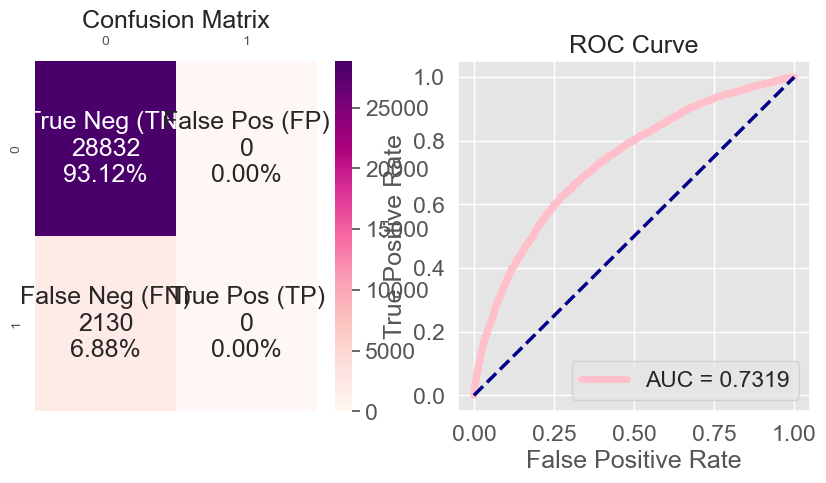

True negative =  28832
False positive =  0
False negative =  2130
True positive =  0


In [36]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (10, 10), "matrice_roc_RF.png")


In [37]:
mlflow.log_artifact("matrice_roc_RF.png")

In [38]:
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.5982284326004618

In [39]:
# Ajout des métriques du modèle LGBMClassifier à la DataFrame comparison_baseline
comparison_baseline_rf = pd.DataFrame(
        {
            "Modele": "RandomForestClassifier basal",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[1],                          # Utilisation de l'index 1 pour ajouter une deuxième ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance pour les deux modèles (Régression logistique et LGBMClassifier)
comparison_baseline = pd.concat([comparison_baseline, comparison_baseline_rf])
comparison_baseline

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Régression logistique basal,0.931400,0.743208,0.00892,0.017576,19,0.593750,2111,0.601543,0.061767
1,LGBMClassifier basal,0.931174,0.760506,0.00939,0.018425,20,0.487805,2110,0.601565,0.879277
1,RandomForestClassifier basal,0.931206,0.731945,0.00000,0.000000,0,0.000000,2130,0.598228,1.400513


#### Traitement de la classification déséquilibrée
#### Class_weight

#### régression logistique

In [40]:
# Vérifiez si un run MLflow est actif
if mlflow.active_run():
    # Si un run est actif, terminez-le
    mlflow.end_run()

In [41]:
# Définition des hyperparamètres optimaux pour le modèle de régression logistique
best_params = LogisticRegression(
    C=0.1,  # Paramètre de régularisation inverse (plus petit est C, plus forte est la régularisation),
    penalty= 'l2',
    class_weight='balanced',  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
)

In [42]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(best_params, X_train, y_train, X_test, y_test, "Régression logistique class_weight", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.330306
1          399406              0.317299
2          168652              0.582255
3          317387              0.219939
4          371921              0.709565
...           ...                   ...
30957      268716              0.443928
30958      398091              0.171580
30959      228535              0.299482
30960      107632              0.368253
30961      343857              0.663027

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.6882630321038693 pour la méthode Régression logistique class_weight.
 
 
Le score de précision est de 0.1374590321958743 pour la méthode Régression logistique class_weight.
 
 
Le score recall est de 0.6694835680751173 pour la méthode Régression logistique class_weight.
 
 
Le score f1 est de 0.22808701215611002 pour la méthode Régression logistique class_weight.
 
 
Le score AUC est de 0.7431246189679699 pour la méth

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/15 15:07:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 82
Created version '82' of model 'CreditModels'.


In [43]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),19884 (TN),8948 (FP)
Real Positive (1),704 (FN),1426 (TP)


In [44]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Résumé :')
print(classification_report(y_test, prediction))

AUC : 0.7431
Résumé :
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.80     28832
         1.0       0.14      0.67      0.23      2130

    accuracy                           0.69     30962
   macro avg       0.55      0.68      0.52     30962
weighted avg       0.91      0.69      0.77     30962



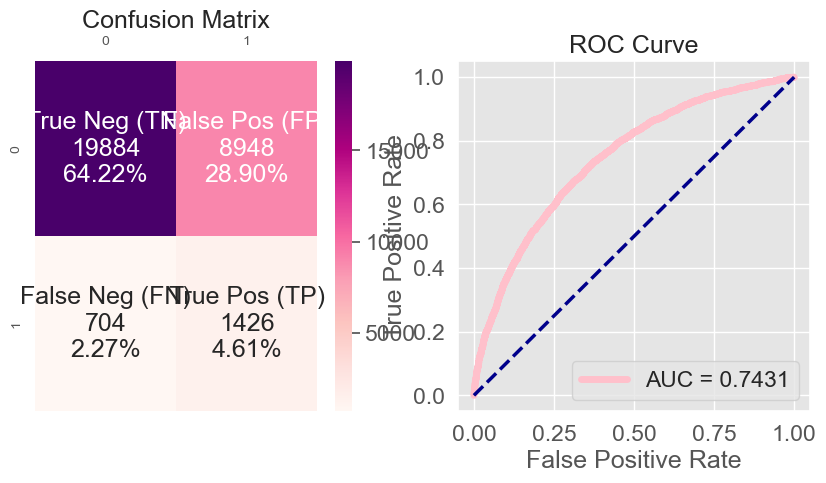

True negative =  19884
False positive =  8948
False negative =  704
True positive =  1426


In [45]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (10, 10), "matrice_roc_RL_cw.png")

In [46]:
mlflow.log_artifact("matrice_roc_RL_cw.png")

In [47]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6815479334228675

In [48]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_class_weight_rl = pd.DataFrame(
        {
            "Modele": "Régression Logistique class_weight",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[2],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_baseline, comparison_class_weight_rl])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Régression logistique basal,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.061767
1,LGBMClassifier basal,0.931174,0.760506,0.009390,0.018425,20,0.487805,2110,0.601565,0.879277
1,RandomForestClassifier basal,0.931206,0.731945,0.000000,0.000000,0,0.000000,2130,0.598228,1.400513
2,Régression Logistique class_weight,0.688263,0.743125,0.669484,0.228087,1426,0.137459,704,0.681548,0.047846


#### lgbm

In [49]:
# Vérifiez si un run MLflow est actif
if mlflow.active_run():
    # Si un run est actif, terminez-le
    mlflow.end_run()

In [50]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_params = LGBMClassifier(
    learning_rate= 0.01, 
    n_estimators= 1300,
    class_weight='balanced',  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    )

In [51]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train, y_train, X_test, y_test, "LGBMClassifier class_weight", file_name=None)

Exécution 
 
[LightGBM] [Info] Number of positive: 8654, number of negative: 115191
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10893
[LightGBM] [Info] Number of data points in the train set: 123845, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
       SK_ID_CURR  positive_probability
0          316145              0.275904
1          399406              0.337614
2          168652              0.513336
3          317387              0.267380
4          371921              0.762167
...           ...                   ...
30957      268716              0.355266
30958      398091              0.333925
30959      228535              0.244642
30960      107632              0.371214
30961      343857              0.549967

[30962 r

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/15 15:09:22 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 83
Created version '83' of model 'CreditModels'.


In [52]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),21524 (TN),7308 (FP)
Real Positive (1),768 (FN),1362 (TP)


In [53]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Résumé:')
print(classification_report(y_test, prediction))

AUC : 0.7610
Résumé:
              precision    recall  f1-score   support

         0.0       0.97      0.75      0.84     28832
         1.0       0.16      0.64      0.25      2130

    accuracy                           0.74     30962
   macro avg       0.56      0.69      0.55     30962
weighted avg       0.91      0.74      0.80     30962



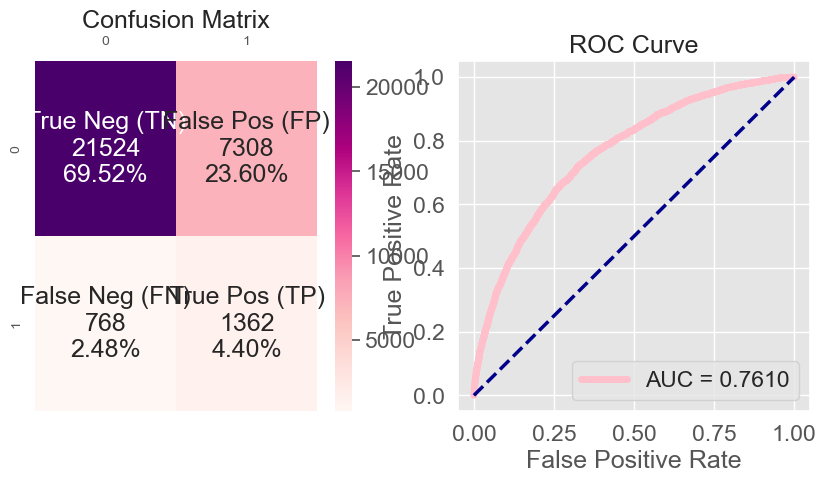

True negative =  21524
False positive =  7308
False negative =  768
True positive =  1362


In [54]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (10, 10), "matrice_roc_LGBM_cw.png")

In [55]:
mlflow.log_artifact("matrice_roc_LGBM_cw.png")

In [56]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.7035039007680816

In [57]:
comparison_class_weight_lgbm = pd.DataFrame(
        {
         "Modele": "LGBMClassifier class_weight",
         "Accuracy": accuracy,
         "AUC": AUC,
         "Recall class 1":recall,
         "F1":f1,   
         "TP":tp,
         "Precision":precision,
         "FN":fn,
         "score Gain":score_gain,
         "time": prediction_time
        },
        index=[3],
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_class_weight_lgbm])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Régression logistique basal,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.061767
1,LGBMClassifier basal,0.931174,0.760506,0.009390,0.018425,20,0.487805,2110,0.601565,0.879277
1,RandomForestClassifier basal,0.931206,0.731945,0.000000,0.000000,0,0.000000,2130,0.598228,1.400513
2,Régression Logistique class_weight,0.688263,0.743125,0.669484,0.228087,1426,0.137459,704,0.681548,0.047846
3,LGBMClassifier class_weight,0.739164,0.760961,0.639437,0.252222,1362,0.157093,768,0.703504,0.940962


#### RandomForest Classifier

In [58]:
# Vérifiez si un run MLflow est actif
if mlflow.active_run():
    # Si un run est actif, terminez-le
    mlflow.end_run()

In [59]:
# Définition des hyperparamètres 
best_params = RandomForestClassifier(
    max_depth=10, n_estimators= 200, class_weight='balanced')

In [60]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(best_params, X_train, y_train, X_test, y_test, "RandomForest classifier class_weight", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.344060
1          399406              0.361096
2          168652              0.497273
3          317387              0.288003
4          371921              0.617455
...           ...                   ...
30957      268716              0.332562
30958      398091              0.403289
30959      228535              0.305376
30960      107632              0.475909
30961      343857              0.611927

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.780052968154512 pour la méthode RandomForest classifier class_weight.
 
 
Le score de précision est de 0.15445953927938572 pour la méthode RandomForest classifier class_weight.
 
 
Le score recall est de 0.49107981220657276 pour la méthode RandomForest classifier class_weight.
 
 
Le score f1 est de 0.23500337002920693 pour la méthode RandomForest classifier class_weight.
 
 
Le score AUC est de 0.7218332004606254 pou

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/15 15:11:27 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 84
Created version '84' of model 'CreditModels'.


In [61]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),23106 (TN),5726 (FP)
Real Positive (1),1084 (FN),1046 (TP)


In [62]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Résumé:')
print(classification_report(y_test, prediction))

AUC : 0.7218
Résumé:
              precision    recall  f1-score   support

         0.0       0.96      0.80      0.87     28832
         1.0       0.15      0.49      0.24      2130

    accuracy                           0.78     30962
   macro avg       0.55      0.65      0.55     30962
weighted avg       0.90      0.78      0.83     30962



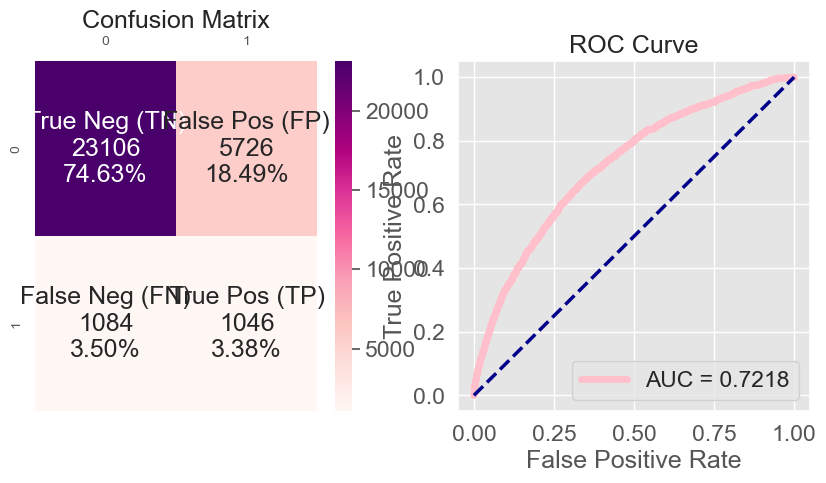

True negative =  23106
False positive =  5726
False negative =  1084
True positive =  1046


In [63]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (10, 10), "matrice_roc_RF_cw.png")

In [64]:
mlflow.log_artifact("matrice_roc_RF_cw.png")

In [65]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6767229021110927

In [66]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_class_weight_rf = pd.DataFrame(
        {
            "Modele": "RandomForest classifier class_weight",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[2],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_class_weight_rf])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Régression logistique basal,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.061767
1,LGBMClassifier basal,0.931174,0.760506,0.009390,0.018425,20,0.487805,2110,0.601565,0.879277
1,RandomForestClassifier basal,0.931206,0.731945,0.000000,0.000000,0,0.000000,2130,0.598228,1.400513
2,Régression Logistique class_weight,0.688263,0.743125,0.669484,0.228087,1426,0.137459,704,0.681548,0.047846
3,LGBMClassifier class_weight,0.739164,0.760961,0.639437,0.252222,1362,0.157093,768,0.703504,0.940962
2,RandomForest classifier class_weight,0.780053,0.721833,0.491080,0.235003,1046,0.154460,1084,0.676723,1.485957


#### Undersampling 

In [67]:
# importer "RandomUnderSampler" pour effectuer une sous-échantillonnage 
# aléatoire des échantillons de la classe majoritaire dans un jeu de données déséquilibré
from imblearn.under_sampling import RandomUnderSampler

In [68]:
print(f"Label 1, Avant d'utiliser RandomUnderSampler: {sum(y_train==1)} ")
print(f"Label 0, Avant d'utiliser RandomUnderSampler: {sum(y_train==0)} ")

Label 1, Avant d'utiliser RandomUnderSampler: 8654 
Label 0, Avant d'utiliser RandomUnderSampler: 115191 


In [69]:
# Création d'une instance de RandomUnderSampler avec un random_state fixé à 0 pour la reproductibilité de l'expérience
rus = RandomUnderSampler(random_state=0)

# Application du sous-échantillonnage aléatoire aux données d'entraînement X_train et y_train
# Les données sous-échantillonnées équilibrées sont stockées dans X_train_under et y_train_under
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

# Conversion des données sous-échantillonnées en DataFrame pandas
# Cela permet de garder les noms de colonnes de X_train pour faciliter l'utilisation ultérieure
X_train_under = pd.DataFrame(X_train_under, columns=X_train.columns)

In [70]:
print(f"Label 1, Après avoir utilisé RandomUnderSampler: {sum(y_train_under==1)}")
print(f"Label 0, Après avoir utilisé RandomUnderSampler: {sum(y_train_under==0)}")

Label 1, Après avoir utilisé RandomUnderSampler: 8654
Label 0, Après avoir utilisé RandomUnderSampler: 8654


In [71]:
X_train_under

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,...,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business_Entity_Type_1,ORGANIZATION_TYPE_Business_Entity_Type_2,ORGANIZATION_TYPE_Business_Entity_Type_3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry_type_1,ORGANIZATION_TYPE_Industry_type_10,ORGANIZATION_TYPE_Industry_type_11,ORGANIZATION_TYPE_Industry_type_12,ORGANIZATION_TYPE_Industry_type_13,ORGANIZATION_TYPE_Industry_type_2,ORGANIZATION_TYPE_Industry_type_3,ORGANIZATION_TYPE_Industry_type_4,ORGANIZATION_TYPE_Industry_type_5,ORGANIZATION_TYPE_Industry_type_6,ORGANIZATION_TYPE_Industry_type_7,ORGANIZATION_TYPE_Industry_type_9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal_Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security_Ministries,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade_type_1,ORGANIZATION_TYPE_Trade_type_2,ORGANIZATION_TYPE_Trade_type_3,ORGANIZATION_TYPE_Trade_type_4,ORGANIZATION_TYPE_Trade_type_5,ORGANIZATION_TYPE_Trade_type_6,ORGANIZATION_TYPE_Trade_type_7,ORGANIZATION_TYPE_Transport_type_1,ORGANIZATION_TYPE_Transport_type_2,ORGANIZATION_TYPE_Transport_type_3,ORGANIZATION_TYPE_Transport_type_4,ORGANIZATION_TYPE_University,HOUSETYPE_MODE_block_of_flats,HOUSETYPE_MODE_specific_housing,HOUSETYPE_MODE_terraced_house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stone_brick,WALLSMATERIAL_MODE_Wooden,MOST_CREDIT_TYPE_Another_type_of_loan,MOST_CREDIT_TYPE_Car_loan,MOST_CREDIT_TYPE_Consumer_credit,MOST_CREDIT_TYPE_Credit_card,MOST_CREDIT_TYPE_Loan_for_business_development,MOST_CREDIT_TYPE_Loan_for_working_capital_replenishment,MOST_CREDIT_TYPE_Microloan,MOST_CREDIT_TYPE_Mortgage
0,0,1,1,0,0,-0.573222,-0.144815,-0.565139,-1.142550,-0.800416,0.018732,-1.090908,-0.853139,1.039624,-0.273951,0.002542,0.458151,-0.46321,0.047807,-0.671139,-0.267116,-0.108965,0.032789,0.100683,0.510382,-0.110786,-0.220085,-0.202500,-0.193282,-0.370518,-0.338066,-0.347398,0.148958,-0.635273,-0.187222,0.124243,-0.597191,-0.119930,-0.705778,0

#### régression logistique

In [74]:
# Vérifiez si un run MLflow est actif
if mlflow.active_run():
    # Si un run est actif, terminez-le
    mlflow.end_run()

In [109]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {"C":[-0.001, -0.01, -0.1, 1, 0.1, 0.01, 0.001, 5, 10, 15, 50, 100]} 
        

# Choisir un score à optimiser
score = 'roc_auc'


# définir le modèle/ estimateur
model = LogisticRegression(random_state=42)

# définir le grid search
lr= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lr.fit(X_train_under, y_train_under)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur hyperparamètre sur le jeu d'entraînement  :")
best_params = lr.best_params_
print(best_params)
print(' ')
print("Meilleur score (roc_auc):")
print(lr.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Meilleur hyperparamètre sur le jeu d'entraînement  :
{'C': 0.1}
 
Meilleur score (roc_auc):
0.7362099026391598


In [75]:
# Définition des hyperparamètres optimaux pour le modèle de régression logistique
best_params = LogisticRegression(
    C=0.1,  # Paramètre de régularisation inverse (plus petit est C, plus forte est la régularisation)
)

In [76]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_under, y_train_under, X_test, y_test, "Régression logistique UnderSampler", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.325710
1          399406              0.288013
2          168652              0.608467
3          317387              0.257283
4          371921              0.605875
...           ...                   ...
30957      268716              0.484868
30958      398091              0.187941
30959      228535              0.316982
30960      107632              0.391851
30961      343857              0.659433

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.6784768425812286 pour la méthode Régression logistique UnderSampler.
 
 
Le score de précision est de 0.1330769952171059 pour la méthode Régression logistique UnderSampler.
 
 
Le score recall est de 0.6661971830985915 pour la méthode Régression logistique UnderSampler.
 
 
Le score f1 est de 0.22184006878761825 pour la méthode Régression logistique UnderSampler.
 
 
Le score AUC est de 0.739970960148609 pour la métho

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/15 15:12:02 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 85
Created version '85' of model 'CreditModels'.


In [77]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),19588 (TN),9244 (FP)
Real Positive (1),711 (FN),1419 (TP)


In [78]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Résumé :')
print(classification_report(y_test, prediction))

AUC : 0.7400
Résumé :
              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80     28832
         1.0       0.13      0.67      0.22      2130

    accuracy                           0.68     30962
   macro avg       0.55      0.67      0.51     30962
weighted avg       0.91      0.68      0.76     30962



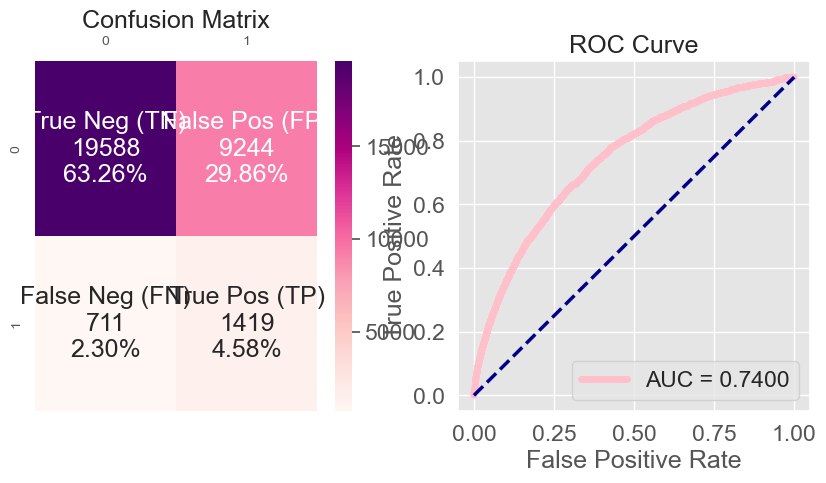

True negative =  19588
False positive =  9244
False negative =  711
True positive =  1419


In [79]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (10, 10), "matrice_roc_RL_under.png")

In [80]:
mlflow.log_artifact("matrice_roc_RL_under.png")

In [81]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6740859225278788

In [82]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_RandomUnderSampler_rl = pd.DataFrame(
        {
            "Modele": "Régression Logistique UnderSampler",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[4],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_RandomUnderSampler_rl])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Régression logistique basal,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.061767
1,LGBMClassifier basal,0.931174,0.760506,0.009390,0.018425,20,0.487805,2110,0.601565,0.879277
1,RandomForestClassifier basal,0.931206,0.731945,0.000000,0.000000,0,0.000000,2130,0.598228,1.400513
2,Régression Logistique class_weight,0.688263,0.743125,0.669484,0.228087,1426,0.137459,704,0.681548,0.047846
3,LGBMClassifier class_weight,0.739164,0.760961,0.639437,0.252222,1362,0.157093,768,0.703504,0.940962
2,RandomForest classifier class_weight,0.780053,0.721833,0.491080,0.235003,1046,0.154460,1084,0.676723,1.485957
4,Régression Logistique UnderSampler,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.038105


#### lgbm

In [83]:
# Vérifiez si un run MLflow est actif
if mlflow.active_run():
    # Si un run est actif, terminez-le
    mlflow.end_run()

In [17]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {
        'n_estimators' : np.arange(500, 1500, 100),
        'learning_rate' : [1, 0.1, 0.01, 0.001]
        }

# Choisir un score à optimiser
score = 'roc_auc'


# define the model/ estimator
model = LGBMClassifier(objective='binary', random_state=42)

# define the grid search
lgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  

# Optimiser ce régresseur sur le jeu d'entraînement
lgbm.fit(X_train_under, y_train_under, eval_metric='auc')

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lgbm.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lgbm.best_score_) 

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[LightGBM] [Info] Number of positive: 8654, number of negative: 8654
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10024
[LightGBM] [Info] Number of data points in the train set: 17308, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'learning_rate': 0.01, 'n_estimators': 700}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.7504177231253573


In [84]:
best_params = LGBMClassifier(
    learning_rate= 0.01, 
    n_estimators= 700,
    )

In [85]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_under, y_train_under, X_test, y_test, "LGBMClassifier UnderSampler", file_name=None)

Exécution 
 
[LightGBM] [Info] Number of positive: 8654, number of negative: 8654
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10024
[LightGBM] [Info] Number of data points in the train set: 17308, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
       SK_ID_CURR  positive_probability
0          316145              0.342801
1          399406              0.328831
2          168652              0.503154
3          317387              0.468453
4          371921              0.767843
...           ...                   ...
30957      268716              0.422637
30958      398091              0.332716
30959      228535              0.303374
30960      107632              0.383717
30961      343857              0.581611

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'acc

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/15 15:12:36 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 86
Created version '86' of model 'CreditModels'.


In [86]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),19916 (TN),8916 (FP)
Real Positive (1),674 (FN),1456 (TP)


In [87]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Résumé :')
print(classification_report(y_test, prediction))

AUC : 0.7540
Résumé :
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81     28832
         1.0       0.14      0.68      0.23      2130

    accuracy                           0.69     30962
   macro avg       0.55      0.69      0.52     30962
weighted avg       0.91      0.69      0.77     30962



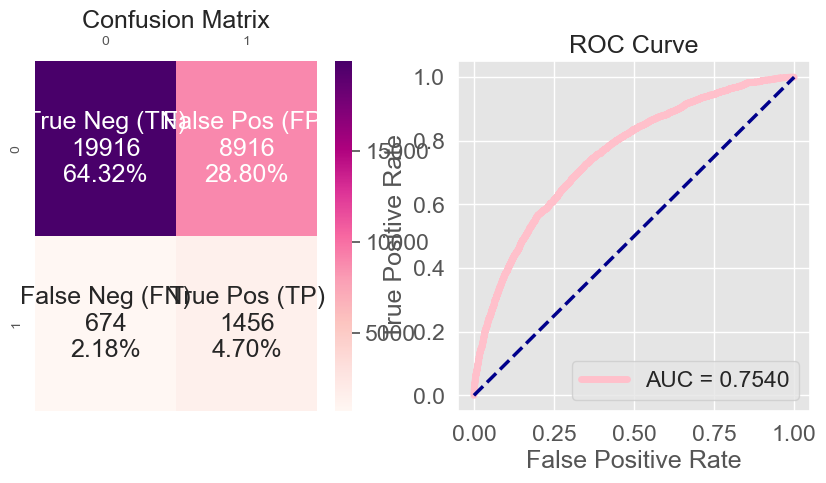

True negative =  19916
False positive =  8916
False negative =  674
True positive =  1456


In [88]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (10, 10), "matrice_roc_LGBM_under.png")

In [89]:
mlflow.log_artifact("matrice_roc_LGBM_under.png")

In [90]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6878706484178122

In [91]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_RandomUnderSampler_lgbm = pd.DataFrame(
        {
            "Modele": "LGBMClassifier UnderSampler",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[5],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_RandomUnderSampler_lgbm])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Régression logistique basal,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.061767
1,LGBMClassifier basal,0.931174,0.760506,0.009390,0.018425,20,0.487805,2110,0.601565,0.879277
1,RandomForestClassifier basal,0.931206,0.731945,0.000000,0.000000,0,0.000000,2130,0.598228,1.400513
2,Régression Logistique class_weight,0.688263,0.743125,0.669484,0.228087,1426,0.137459,704,0.681548,0.047846
3,LGBMClassifier class_weight,0.739164,0.760961,0.639437,0.252222,1362,0.157093,768,0.703504,0.940962
2,RandomForest classifier class_weight,0.780053,0.721833,0.491080,0.235003,1046,0.154460,1084,0.676723,1.485957
4,Régression Logistique UnderSampler,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.038105
5,LGBMClassifier UnderSampler,0.690265,0.754021,0.683568,0.232923,1456,0.140378,674,0.687871,0.531175


#### RandomForest Classifier

In [92]:
# Vérifiez si un run MLflow est actif
if mlflow.active_run():
    # Si un run est actif, terminez-le
    mlflow.end_run()

In [133]:
rf = RandomForestClassifier(random_state = 42)

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10]
}


rf_cv = GridSearchCV(
    rf,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

rf_cv.fit(X_train_under, y_train_under)

print("Meilleurs hyperparamètres sur le jeu d'entraînement :")
best_params = rf_cv.best_params_
print(best_params)
print(' ')
print("Meilleur score sur le jeu d'entraînement (roc_auc):")
print(rf_cv.best_score_)

Meilleurs hyperparamètres sur le jeu d'entraînement :
{'max_depth': 10, 'n_estimators': 200}
 
Meilleur score sur le jeu d'entraînement (roc_auc):
0.7293088820014206


In [93]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_params = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)

In [94]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_under, y_train_under, X_test, y_test, "RandomForest Classifier UnderSampler", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.399141
1          399406              0.425844
2          168652              0.556133
3          317387              0.392822
4          371921              0.655269
...           ...                   ...
30957      268716              0.425941
30958      398091              0.449857
30959      228535              0.354341
30960      107632              0.497301
30961      343857              0.609214

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.6716943349912796 pour la méthode RandomForest Classifier UnderSampler.
 
 
Le score de précision est de 0.13179360278617908 pour la méthode RandomForest Classifier UnderSampler.
 
 
Le score recall est de 0.6751173708920187 pour la méthode RandomForest Classifier UnderSampler.
 
 
Le score f1 est de 0.22053523502798864 pour la méthode RandomForest Classifier UnderSampler.
 
 
Le score AUC est de 0.7293049291866627 pou

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/15 15:13:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 87
Created version '87' of model 'CreditModels'.


In [95]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),19359 (TN),9473 (FP)
Real Positive (1),692 (FN),1438 (TP)


In [96]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Résumé :')
print(classification_report(y_test, prediction))

AUC : 0.7293
Résumé :
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79     28832
         1.0       0.13      0.68      0.22      2130

    accuracy                           0.67     30962
   macro avg       0.55      0.67      0.51     30962
weighted avg       0.91      0.67      0.75     30962



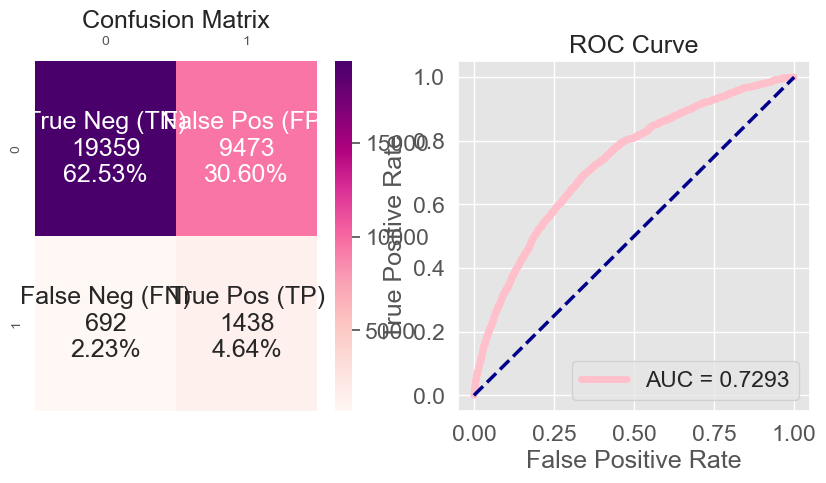

True negative =  19359
False positive =  9473
False negative =  692
True positive =  1438


In [97]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (10, 10), "matrice_roc_RF_under.png")

In [98]:
mlflow.log_artifact("matrice_roc_RF_under.png")

In [99]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.672918332855483

In [100]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_RandomUnderSampler_rf = pd.DataFrame(
        {
            "Modele": "RandomForest Classifier UnderSampler",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[5],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_RandomUnderSampler_rf])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Régression logistique basal,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.061767
1,LGBMClassifier basal,0.931174,0.760506,0.009390,0.018425,20,0.487805,2110,0.601565,0.879277
1,RandomForestClassifier basal,0.931206,0.731945,0.000000,0.000000,0,0.000000,2130,0.598228,1.400513
2,Régression Logistique class_weight,0.688263,0.743125,0.669484,0.228087,1426,0.137459,704,0.681548,0.047846
3,LGBMClassifier class_weight,0.739164,0.760961,0.639437,0.252222,1362,0.157093,768,0.703504,0.940962
2,RandomForest classifier class_weight,0.780053,0.721833,0.491080,0.235003,1046,0.154460,1084,0.676723,1.485957
4,Régression Logistique UnderSampler,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.038105
5,LGBMClassifier UnderSampler,0.690265,0.754021,0.683568,0.232923,1456,0.140378,674,0.687871,0.531175
5,RandomForest Classifier UnderSampler,0.671694,0.729305,0.675117,0.220535,1438,0.131794,692,0.672918,1.415787


#### oversampling

In [101]:
# importer "RandomOverSampler" pour effectuer un suréchantillonnage
from imblearn.over_sampling import RandomOverSampler

In [102]:
print(f"Label 1, Avant d'utiliser RandomOverSampler: {sum(y_train==1)} ")
print(f"Label 0, Avant d'utiliser RandomOverSampler: {sum(y_train==0)} ")

Label 1, Avant d'utiliser RandomOverSampler: 8654 
Label 0, Avant d'utiliser RandomOverSampler: 115191 


In [103]:
# Création d'une instance de RandomOverSampler avec un random_state fixé à 0 pour la reproductibilité
ros = RandomOverSampler(random_state=0)

# Application du suréchantillonnage aléatoire aux données d'entraînement X_train et y_train
# Les données suréchantillonnage équilibrées sont stockées dans X_train_under et y_train_under
X_train_over, y_train_over= ros.fit_resample(X_train, y_train)

# Conversion des données suréchantillonnage en DataFrame pandas
# Cela permet de garder les noms de colonnes de X_train pour faciliter l'utilisation ultérieure
X_train_over= pd.DataFrame(X_train_over, columns=X_train.columns)

In [104]:
print(f"Label 1, Après avoir utilisé RandomOverSampler: {sum(y_train_over==1)}")
print(f"Label 0, Après avoir utilisé RandomOverSampler: {sum(y_train_over==0)}")

Label 1, Après avoir utilisé RandomOverSampler: 115191
Label 0, Après avoir utilisé RandomOverSampler: 115191


#### régression logistique

In [105]:
# Vérifiez si un run MLflow est actif
if mlflow.active_run():
    # Si un run est actif, terminez-le
    mlflow.end_run()

In [145]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {"C":[-0.001, -0.01, -0.1, 1, 0.1, 0.01, 0.001, 5, 10, 15, 50, 100]} 
        

# Choisir un score à optimiser
score = 'roc_auc'


# définir le modèle/ estimateur
model = LogisticRegression(random_state=42)

# définir le grid search
lr= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lr.fit(X_train_over, y_train_over)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lr.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lr.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'C': 0.1}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.7446863128436056


In [106]:
# Définition des hyperparamètres optimaux pour le modèle de régression logistique
best_params = LogisticRegression(
    C=0.1
)

In [107]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_over, y_train_over, X_test, y_test, "Regression logistique OverSampler", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.329498
1          399406              0.326812
2          168652              0.586478
3          317387              0.215325
4          371921              0.681872
...           ...                   ...
30957      268716              0.451193
30958      398091              0.182441
30959      228535              0.290289
30960      107632              0.363723
30961      343857              0.660310

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.6885860086557716 pour la méthode Regression logistique OverSampler.
 
 
Le score de précision est de 0.13724164574077652 pour la méthode Regression logistique OverSampler.
 
 
Le score recall est de 0.6671361502347418 pour la méthode Regression logistique OverSampler.
 
 
Le score f1 est de 0.22765139378404362 pour la méthode Regression logistique OverSampler.
 
 
Le score AUC est de 0.7428130520079411 pour la méthode

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/15 15:14:33 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 88
Created version '88' of model 'CreditModels'.


In [108]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),19899 (TN),8933 (FP)
Real Positive (1),709 (FN),1421 (TP)


In [109]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Résumé :')
print(classification_report(y_test, prediction))

AUC : 0.7428
Résumé :
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.80     28832
         1.0       0.14      0.67      0.23      2130

    accuracy                           0.69     30962
   macro avg       0.55      0.68      0.52     30962
weighted avg       0.91      0.69      0.77     30962



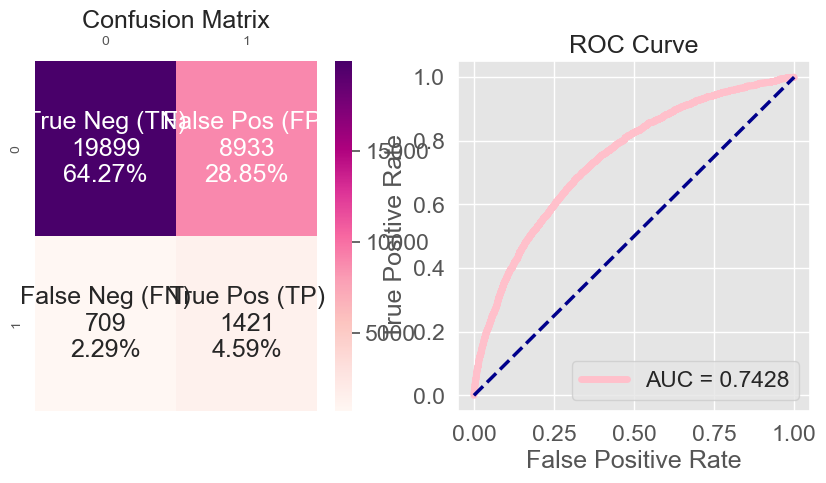

True negative =  19899
False positive =  8933
False negative =  709
True positive =  1421


In [110]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (10, 10), "matrice_roc_RL_over.png")

In [111]:
mlflow.log_artifact("matrice_roc_RL_over.png")

In [112]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6809160391736709

In [113]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_RandomOverSampler_lr = pd.DataFrame(
        {
            "Modele": "Regression Logistique OverSampler",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[6],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_RandomOverSampler_lr])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Régression logistique basal,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.061767
1,LGBMClassifier basal,0.931174,0.760506,0.009390,0.018425,20,0.487805,2110,0.601565,0.879277
1,RandomForestClassifier basal,0.931206,0.731945,0.000000,0.000000,0,0.000000,2130,0.598228,1.400513
2,Régression Logistique class_weight,0.688263,0.743125,0.669484,0.228087,1426,0.137459,704,0.681548,0.047846
3,LGBMClassifier class_weight,0.739164,0.760961,0.639437,0.252222,1362,0.157093,768,0.703504,0.940962
2,RandomForest classifier class_weight,0.780053,0.721833,0.491080,0.235003,1046,0.154460,1084,0.676723,1.485957
4,Régression Logistique UnderSampler,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.038105
5,LGBMClassifier UnderSampler,0.690265,0.754021,0.683568,0.232923,1456,0.140378,674,0.687871,0.531175
5,RandomForest Classifier UnderSampler,0.671694,0.729305,0.675117,0.220535,1438,0.131794,692,0.672918,1.415787
6,Regression Logistique OverSampler,0.688586,0.742813,0.667136,0.227651,1421,0.137242,709,0.680916,0.038640


#### lgbm

In [114]:
# Vérifiez si un run MLflow est actif
if mlflow.active_run():
    # Si un run est actif, terminez-le
    mlflow.end_run()

In [22]:
param_grid = {
        'n_estimators' : np.arange(500, 1500, 100),
        'learning_rate' : [1, 0.1, 0.01, 0.001]
        }

score = 'roc_auc'


model = LGBMClassifier(objective='binary', random_state=42)

lgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2) 

lgbm.fit(X_train_over, y_train_over)

print("Meilleurs hyperparamètres sur le jeu d'entraînement :")
best_params = lgbm.best_params_
print(best_params)
print(' ')
print("Meilleur score sur le jeu d'entraînement (roc_auc):")
print(lgbm.best_score_)

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[LightGBM] [Info] Number of positive: 115191, number of negative: 115191
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10902
[LightGBM] [Info] Number of data points in the train set: 230382, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleurs hyperparamètres sur le jeu d'entraînement :
{'learning_rate': 0.1, 'n_estimators': 1400}
 
Meilleur score sur le jeu d'entraînement (roc_auc):
0.9921900703650043


In [115]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_params = LGBMClassifier(
    learning_rate=0.1,  
    n_estimators=1400
    )

In [116]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_over, y_train_over, X_test, y_test, "LGBMClassifier OverSampler", file_name=None)

Exécution 
 
[LightGBM] [Info] Number of positive: 115191, number of negative: 115191
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10857
[LightGBM] [Info] Number of data points in the train set: 230382, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
       SK_ID_CURR  positive_probability
0          316145              0.234620
1          399406              0.126911
2          168652              0.358002
3          317387              0.099062
4          371921              0.453239
...           ...                   ...
30957      268716              0.102261
30958      398091              0.139649
30959      228535              0.070381
30960      107632              0.195837
30961      343857              0.065136

[30962 rows x 2 columns]
Qualité de la classification 
 
 


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/15 15:16:32 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 89
Created version '89' of model 'CreditModels'.


In [117]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),26554 (TN),2278 (FP)
Real Positive (1),1568 (FN),562 (TP)


In [118]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Résumé :')
print(classification_report(y_test, prediction))

AUC : 0.6988
Résumé :
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93     28832
         1.0       0.20      0.26      0.23      2130

    accuracy                           0.88     30962
   macro avg       0.57      0.59      0.58     30962
weighted avg       0.89      0.88      0.88     30962



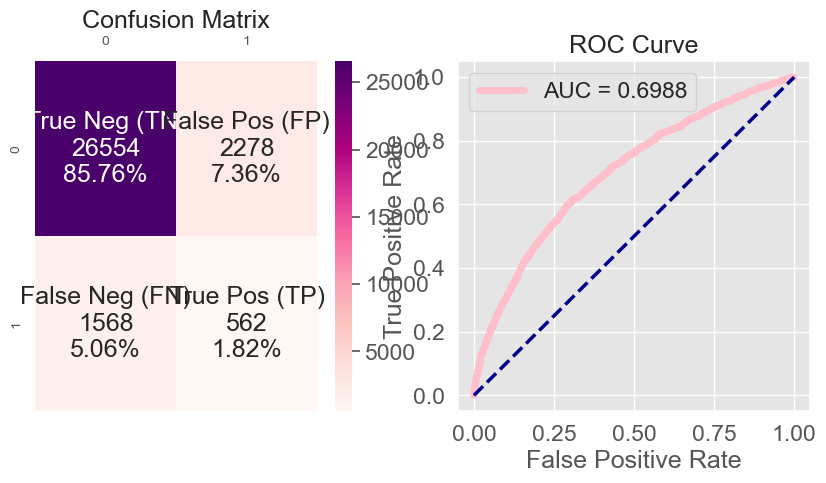

True negative =  26554
False positive =  2278
False negative =  1568
True positive =  562


In [119]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (10, 10), "matrice_roc_LGBM_over.png")

In [120]:
mlflow.log_artifact("matrice_roc_LGBM_over.png")

In [121]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6569700765063604

In [122]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_RandomOverSampler_lgbm = pd.DataFrame(
        {
            "Modele": "LGBMClassifier OverSampler",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[7],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_RandomOverSampler_lgbm])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Régression logistique basal,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.061767
1,LGBMClassifier basal,0.931174,0.760506,0.009390,0.018425,20,0.487805,2110,0.601565,0.879277
1,RandomForestClassifier basal,0.931206,0.731945,0.000000,0.000000,0,0.000000,2130,0.598228,1.400513
2,Régression Logistique class_weight,0.688263,0.743125,0.669484,0.228087,1426,0.137459,704,0.681548,0.047846
3,LGBMClassifier class_weight,0.739164,0.760961,0.639437,0.252222,1362,0.157093,768,0.703504,0.940962
2,RandomForest classifier class_weight,0.780053,0.721833,0.491080,0.235003,1046,0.154460,1084,0.676723,1.485957
4,Régression Logistique UnderSampler,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.038105
5,LGBMClassifier UnderSampler,0.690265,0.754021,0.683568,0.232923,1456,0.140378,674,0.687871,0.531175
5,RandomForest Classifier UnderSampler,0.671694,0.729305,0.675117,0.220535,1438,0.131794,692,0.672918,1.415787
6,Regression Logistique OverSampler,0.688586,0.742813,0.667136,0.227651,1421,0.137242,709,0.680916,0.038640


#### RandomForest Classifier

In [123]:
# Vérifiez si un run MLflow est actif
if mlflow.active_run():
    # Si un run est actif, terminez-le
    mlflow.end_run()

In [116]:
rf = RandomForestClassifier(random_state = 42)

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10]
}


rf_cv = GridSearchCV(
    rf,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)


rf_cv.fit(X_train_over, y_train_over)

print("Meilleurs hyperparamètres sur le jeu d'entraînement :")
best_params = rf_cv.best_params_
print(best_params)
print(' ')
print("Meilleur score sur le jeu d'entraînement (roc_auc):")
print(rf_cv.best_score_)

Meilleurs hyperparamètres sur le jeu d'entraînement :
{'max_depth': 10, 'n_estimators': 200}
 
Meilleur score sur le jeu d'entraînement (roc_auc):
0.8664428688993091


In [124]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_params = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)

In [125]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_over, y_train_over, X_test, y_test, "RandomForest Classifier OverSampler", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.358065
1          399406              0.372483
2          168652              0.546697
3          317387              0.325400
4          371921              0.660989
...           ...                   ...
30957      268716              0.350514
30958      398091              0.408374
30959      228535              0.327492
30960      107632              0.495435
30961      343857              0.610013

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.7484981590336541 pour la méthode RandomForest Classifier OverSampler.
 
 
Le score de précision est de 0.14972136222910218 pour la méthode RandomForest Classifier OverSampler.
 
 
Le score recall est de 0.5676056338028169 pour la méthode RandomForest Classifier OverSampler.
 
 
Le score f1 est de 0.2369426751592357 pour la méthode RandomForest Classifier OverSampler.
 
 
Le score AUC est de 0.7266837870545506 pour la 

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/15 15:19:36 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 90
Created version '90' of model 'CreditModels'.


In [126]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),21966 (TN),6866 (FP)
Real Positive (1),921 (FN),1209 (TP)


In [127]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Résumé :')
print(classification_report(y_test, prediction))

AUC : 0.7267
Résumé :
              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85     28832
         1.0       0.15      0.57      0.24      2130

    accuracy                           0.75     30962
   macro avg       0.55      0.66      0.54     30962
weighted avg       0.90      0.75      0.81     30962



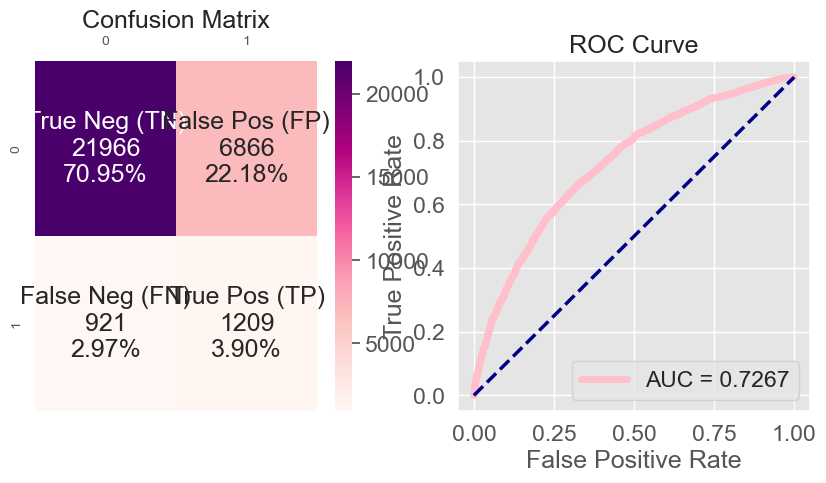

True negative =  21966
False positive =  6866
False negative =  921
True positive =  1209


In [128]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (10, 10), "matrice_roc_RF_over.png")

In [129]:
mlflow.log_artifact("matrice_roc_RF_over.png")

In [130]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.683815207714014

In [131]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_RandomOverSampler_rf = pd.DataFrame(
        {
            "Modele": "RandomForest Classifier OverSampler",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[7],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_RandomOverSampler_rf])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Régression logistique basal,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.061767
1,LGBMClassifier basal,0.931174,0.760506,0.009390,0.018425,20,0.487805,2110,0.601565,0.879277
1,RandomForestClassifier basal,0.931206,0.731945,0.000000,0.000000,0,0.000000,2130,0.598228,1.400513
2,Régression Logistique class_weight,0.688263,0.743125,0.669484,0.228087,1426,0.137459,704,0.681548,0.047846
3,LGBMClassifier class_weight,0.739164,0.760961,0.639437,0.252222,1362,0.157093,768,0.703504,0.940962
2,RandomForest classifier class_weight,0.780053,0.721833,0.491080,0.235003,1046,0.154460,1084,0.676723,1.485957
4,Régression Logistique UnderSampler,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.038105
5,LGBMClassifier UnderSampler,0.690265,0.754021,0.683568,0.232923,1456,0.140378,674,0.687871,0.531175
5,RandomForest Classifier UnderSampler,0.671694,0.729305,0.675117,0.220535,1438,0.131794,692,0.672918,1.415787
6,Regression Logistique OverSampler,0.688586,0.742813,0.667136,0.227651,1421,0.137242,709,0.680916,0.038640


#### Oversampling (SMOTE)

In [132]:
# importer "SMOTE" pour effectuer un suréchantillonnage
from imblearn.over_sampling import SMOTE

In [133]:
print(f"Label 1, Avant d'utiliser SMOTE: {sum(y_train==1)} ")
print(f"Label 0, Avant d'utiliser SMOTE: {sum(y_train==0)} ")

Label 1, Avant d'utiliser SMOTE: 8654 
Label 0, Avant d'utiliser SMOTE: 115191 


In [134]:
# Création d'une instance de SMOTE avec un random_state fixé à 0 pour la reproductibilité
sm = SMOTE(random_state=0)

# Application du suréchantillonnage aléatoire aux données d'entraînement X_train et y_train
# Les données suréchantillonnage équilibrées sont stockées dans X_train_under et y_train_under
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Conversion des données suréchantillonnage en DataFrame pandas
# Cela permet de garder les noms de colonnes de X_train pour faciliter l'utilisation ultérieure
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)

In [135]:
print(f"Label 1, Après avoir utilisé SMOTE: {sum(y_train_resampled==1)}")
print(f"Label 0, Après avoir utilisé SMOTE: {sum(y_train_resampled==0)}")

Label 1, Après avoir utilisé SMOTE: 115191
Label 0, Après avoir utilisé SMOTE: 115191


#### régression logistique

In [136]:
# Vérifiez si un run MLflow est actif
if mlflow.active_run():
    # Si un run est actif, terminez-le
    mlflow.end_run()

In [110]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {"C":[-0.001, -0.01, -0.1, 1, 0.1, 0.01, 0.001, 5, 10, 15, 50, 100]} 
        

# Choisir un score à optimiser
score = 'roc_auc'


# définir le modèle/ estimateur
model = LogisticRegression(random_state=42)

# définir le grid search
lr= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lr.fit(X_train_resampled, y_train_resampled)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lr.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lr.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'C': 0.01}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.971585190481375
time: 2min 1s (started: 2023-09-28 18:37:11 +02:00)


In [137]:
# Définition des hyperparamètres optimaux pour le modèle de régression logistique
best_params = LogisticRegression(
    C=0.1)

In [138]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_resampled, y_train_resampled, X_test, y_test, "Regression logistique SMOTE", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.051847
1          399406              0.041269
2          168652              0.111246
3          317387              0.022336
4          371921              0.188475
...           ...                   ...
30957      268716              0.132319
30958      398091              0.024765
30959      228535              0.057348
30960      107632              0.061166
30961      343857              0.158269

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.9307215296169498 pour la méthode Regression logistique SMOTE.
 
 
Le score de précision est de 0.3770491803278688 pour la méthode Regression logistique SMOTE.
 
 
Le score recall est de 0.0107981220657277 pour la méthode Regression logistique SMOTE.
 
 
Le score f1 est de 0.020994979461433135 pour la méthode Regression logistique SMOTE.
 
 
Le score AUC est de 0.7305575475606134 pour la méthode Regression logistique S

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/15 15:19:52 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 91
Created version '91' of model 'CreditModels'.


In [139]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),28794 (TN),38 (FP)
Real Positive (1),2107 (FN),23 (TP)


In [140]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Résumé :')
print(classification_report(y_test, prediction))

AUC : 0.7306
Résumé :
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     28832
         1.0       0.38      0.01      0.02      2130

    accuracy                           0.93     30962
   macro avg       0.65      0.50      0.49     30962
weighted avg       0.89      0.93      0.90     30962



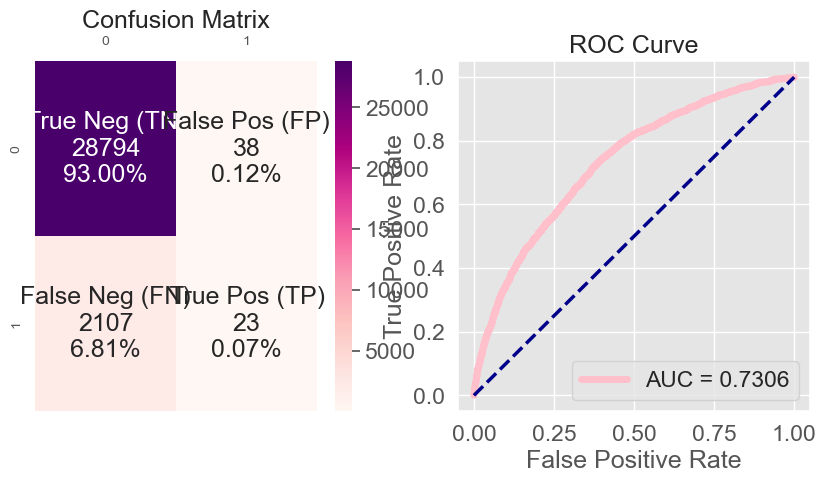

True negative =  28794
False positive =  38
False negative =  2107
True positive =  23


In [141]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (10, 10), "matrice_roc_RL_SMOTE.png")

In [142]:
mlflow.log_artifact("matrice_roc_RL_SMOTE.png")

In [143]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6017783579049027

In [144]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_smote_rl = pd.DataFrame(
        {
            "Modele": "Regression Logistique SMOTE",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[8],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_smote_rl])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Régression logistique basal,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.061767
1,LGBMClassifier basal,0.931174,0.760506,0.009390,0.018425,20,0.487805,2110,0.601565,0.879277
1,RandomForestClassifier basal,0.931206,0.731945,0.000000,0.000000,0,0.000000,2130,0.598228,1.400513
2,Régression Logistique class_weight,0.688263,0.743125,0.669484,0.228087,1426,0.137459,704,0.681548,0.047846
3,LGBMClassifier class_weight,0.739164,0.760961,0.639437,0.252222,1362,0.157093,768,0.703504,0.940962
2,RandomForest classifier class_weight,0.780053,0.721833,0.491080,0.235003,1046,0.154460,1084,0.676723,1.485957
4,Régression Logistique UnderSampler,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.038105
5,LGBMClassifier UnderSampler,0.690265,0.754021,0.683568,0.232923,1456,0.140378,674,0.687871,0.531175
5,RandomForest Classifier UnderSampler,0.671694,0.729305,0.675117,0.220535,1438,0.131794,692,0.672918,1.415787
6,Regression Logistique OverSampler,0.688586,0.742813,0.667136,0.227651,1421,0.137242,709,0.680916,0.038640


#### LGBM

In [145]:
# Vérifiez si un run MLflow est actif
if mlflow.active_run():
    # Si un run est actif, terminez-le
    mlflow.end_run()

In [137]:
param_grid = {
        'n_estimators' : np.arange(500, 1500, 100),
        'learning_rate' : [1, 0.1, 0.01, 0.001]
        }

score = 'roc_auc'


model = LGBMClassifier(objective='binary', random_state=42)

lgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  

lgbm.fit(X_train_resampled, y_train_resampled)

print("Meilleurs hyperparamètres sur le jeu d'entraînement  :")
best_params = lgbm.best_params_
print(best_params)
print(' ')
print("Meilleur score jeu d'entraînement (roc_auc):")
print(lgbm.best_score_)

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[LightGBM] [Info] Number of positive: 115191, number of negative: 115191
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.193557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19479
[LightGBM] [Info] Number of data points in the train set: 230382, number of used features: 202
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleurs hyperparamètres sur le jeu d'entraînement  :
{'learning_rate': 0.01, 'n_estimators': 1200}
 
Meilleur score jeu d'entraînement (roc_auc):
0.9734255027081724


In [146]:
best_params = LGBMClassifier(
    learning_rate=0.01, 
    n_estimators=1200)

In [147]:
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_resampled, y_train_resampled, X_test, y_test, "LGBMClassifier SMOTE", file_name=None)

Exécution 
 
[LightGBM] [Info] Number of positive: 115191, number of negative: 115191
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.200357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19473
[LightGBM] [Info] Number of data points in the train set: 230382, number of used features: 202
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
       SK_ID_CURR  positive_probability
0          316145              0.060019
1          399406              0.053247
2          168652              0.103445
3          317387              0.023981
4          371921              0.287028
...           ...                   ...
30957      268716              0.064645
30958      398091              0.035777
30959      228535              0.039731
30960      107632              0.063775
30961      343857              0.104192

[30962 rows x 2 columns]
Qualité de la classification 
 
 


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/15 15:20:59 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 92
Created version '92' of model 'CreditModels'.


In [148]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),28794 (TN),38 (FP)
Real Positive (1),2103 (FN),27 (TP)


In [149]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Résumé :')
print(classification_report(y_test, prediction))

AUC : 0.7440
Résumé :
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     28832
         1.0       0.42      0.01      0.02      2130

    accuracy                           0.93     30962
   macro avg       0.67      0.51      0.49     30962
weighted avg       0.90      0.93      0.90     30962



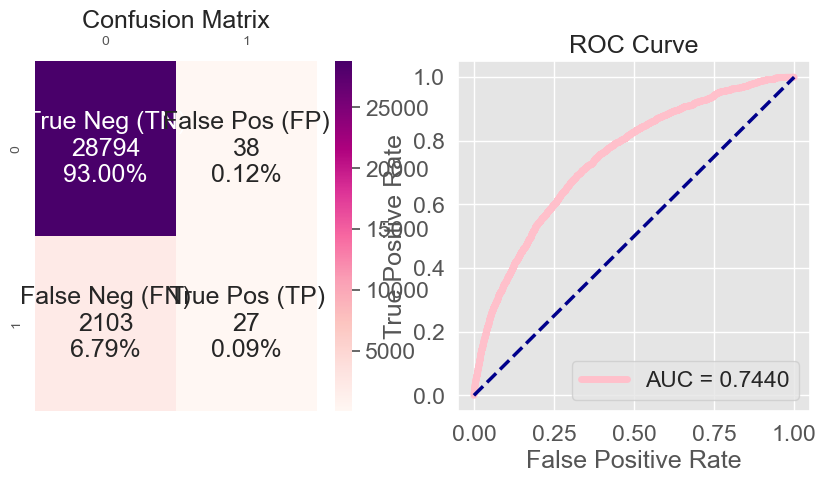

True negative =  28794
False positive =  38
False negative =  2103
True positive =  27


In [150]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (10, 10), "matrice_roc_LGBM_SMOTE.png")

In [151]:
mlflow.log_artifact("matrice_roc_LGBM_SMOTE.png")

In [152]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6025328585009582

In [153]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_smote_lgbm = pd.DataFrame(
        {
            "Modele": "LGBMClassifier SMOTE",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[8],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_smote_lgbm])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Régression logistique basal,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.061767
1,LGBMClassifier basal,0.931174,0.760506,0.009390,0.018425,20,0.487805,2110,0.601565,0.879277
1,RandomForestClassifier basal,0.931206,0.731945,0.000000,0.000000,0,0.000000,2130,0.598228,1.400513
2,Régression Logistique class_weight,0.688263,0.743125,0.669484,0.228087,1426,0.137459,704,0.681548,0.047846
3,LGBMClassifier class_weight,0.739164,0.760961,0.639437,0.252222,1362,0.157093,768,0.703504,0.940962
2,RandomForest classifier class_weight,0.780053,0.721833,0.491080,0.235003,1046,0.154460,1084,0.676723,1.485957
4,Régression Logistique UnderSampler,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.038105
5,LGBMClassifier UnderSampler,0.690265,0.754021,0.683568,0.232923,1456,0.140378,674,0.687871,0.531175
5,RandomForest Classifier UnderSampler,0.671694,0.729305,0.675117,0.220535,1438,0.131794,692,0.672918,1.415787
6,Regression Logistique OverSampler,0.688586,0.742813,0.667136,0.227651,1421,0.137242,709,0.680916,0.038640


#### RandomForest Classifier

In [154]:
# Vérifiez si un run MLflow est actif
if mlflow.active_run():
    # Si un run est actif, terminez-le
    mlflow.end_run()

In [ ]:
rf = RandomForestClassifier(random_state = 42)

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10]
}


rf_cv = GridSearchCV(
    rf,
    param_grid=params,
    scoring="roc_auc",
    cv=4, 
    return_train_score = True,
    n_jobs=-1, verbose=2
)


rf_cv.fit(X_train_resampled, y_train_resampled)

print("Meilleurs hyperparamètres sur le jeu d'entraînement  :")
best_params = rf_cv.best_params_
print(best_params)
print(' ')
print("Meilleur score jeu d'entraînement (roc_auc):")
print(rf_cv.best_score_)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


In [155]:
best_params = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10)

In [156]:
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_resampled, y_train_resampled, X_test, y_test, "RandomForest Classifier SMOTE", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.366593
1          399406              0.383377
2          168652              0.418067
3          317387              0.154162
4          371921              0.429611
...           ...                   ...
30957      268716              0.240713
30958      398091              0.385040
30959      228535              0.301185
30960      107632              0.486857
30961      343857              0.501702

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.8747819908274659 pour la méthode RandomForest Classifier SMOTE.
 
 
Le score de précision est de 0.15650806134486828 pour la méthode RandomForest Classifier SMOTE.
 
 
Le score recall est de 0.18685446009389672 pour la méthode RandomForest Classifier SMOTE.
 
 
Le score f1 est de 0.1703402525144447 pour la méthode RandomForest Classifier SMOTE.
 
 
Le score AUC est de 0.6576264375003257 pour la méthode RandomForest Cl

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/15 15:25:43 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 93
Created version '93' of model 'CreditModels'.


In [157]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),26687 (TN),2145 (FP)
Real Positive (1),1732 (FN),398 (TP)


In [158]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Résumé :')
print(classification_report(y_test, prediction))

AUC : 0.6576
Résumé :
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93     28832
         1.0       0.16      0.19      0.17      2130

    accuracy                           0.87     30962
   macro avg       0.55      0.56      0.55     30962
weighted avg       0.89      0.87      0.88     30962



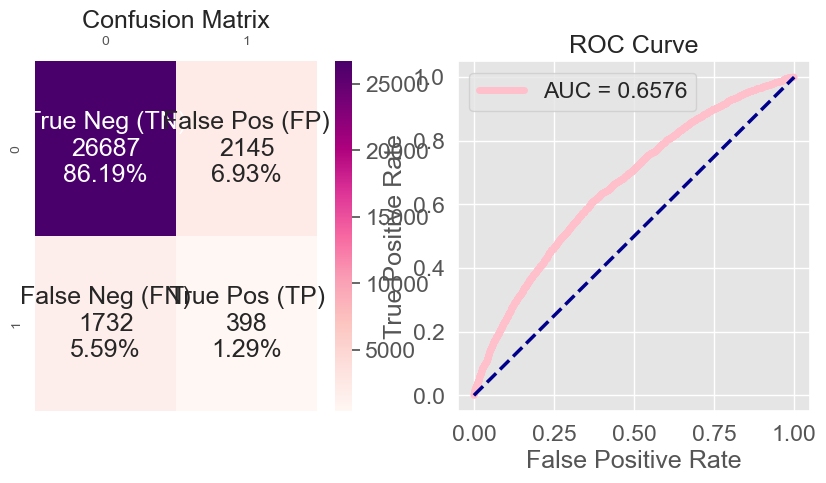

True negative =  26687
False positive =  2145
False negative =  1732
True positive =  398


In [159]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (10, 10), "matrice_roc_RF_SMOTE.png")

In [160]:
mlflow.log_artifact("matrice_roc_RF_SMOTE.png")

In [161]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.628795137998159

In [162]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_smote_rf = pd.DataFrame(
        {
            "Modele": "RandomForest Classifier SMOTE",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[8],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_smote_rf])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Régression logistique basal,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.061767
1,LGBMClassifier basal,0.931174,0.760506,0.009390,0.018425,20,0.487805,2110,0.601565,0.879277
1,RandomForestClassifier basal,0.931206,0.731945,0.000000,0.000000,0,0.000000,2130,0.598228,1.400513
2,Régression Logistique class_weight,0.688263,0.743125,0.669484,0.228087,1426,0.137459,704,0.681548,0.047846
3,LGBMClassifier class_weight,0.739164,0.760961,0.639437,0.252222,1362,0.157093,768,0.703504,0.940962
2,RandomForest classifier class_weight,0.780053,0.721833,0.491080,0.235003,1046,0.154460,1084,0.676723,1.485957
4,Régression Logistique UnderSampler,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.038105
5,LGBMClassifier UnderSampler,0.690265,0.754021,0.683568,0.232923,1456,0.140378,674,0.687871,0.531175
5,RandomForest Classifier UnderSampler,0.671694,0.729305,0.675117,0.220535,1438,0.131794,692,0.672918,1.415787
6,Regression Logistique OverSampler,0.688586,0.742813,0.667136,0.227651,1421,0.137242,709,0.680916,0.038640


On observe:

L'AUC, le Recall, le F1_score sont maximisés avec LGBMClassifier UnderSampler.

Le nombre de TP (LE PRET N'EST PAS ACCORDE ET LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est maximisé avec l'algorithme RandomUnderSampler - LGBMClassifier.

Le nombre de FN ( LE PRET EST ACCORDE MAIS LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est minimisé avec l'algorithme LGBMClassifier UnderSampler.

La métrique score_gain créée montre que c'est avec l'algorithme LGBMClassifier UnderSampler que la Banque peut maximiser ses gains lorsqu'elle acceptera une demande de prêt.

Finalement, le modèle LGBMClassifier UnderSampler semble être le modèle adéquat pour cette étude avec le meilleur recall ce qui évitera d'accorder des prêts à des personnes qui ne peuvent pas rembourser(le but est d'avoir un recall important pour la prédiction des clients défaillants) tout en ayant un gain d'argent important pour la banque (score gain élevé).

#### Analyse avec le meilleur modèle retenu
Exécution au seuil 0.5 (de base dans sklearn)

In [166]:
print(f"Label 1, Avant d'utiliser RandomUnderSampler: {sum(y_train==1)} ")
print(f"Label 0, Avant d'utiliser RandomUnderSampler: {sum(y_train==0)} ")

Label 1, Avant d'utiliser RandomUnderSampler: 8654 
Label 0, Avant d'utiliser RandomUnderSampler: 115191 


In [167]:
# Création d'une instance de RandomUnderSampler avec un random_state fixé à 0 pour la reproductibilité
rus = RandomUnderSampler(random_state=0)

# Application du suréchantillonnage aléatoire aux données d'entraînement X_train et y_train
# Les données suréchantillonnage équilibrées sont stockées dans X_train_under et y_train_under
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

# Conversion des données suréchantillonnage en DataFrame pandas
# Cela permet de garder les noms de colonnes de X_train pour faciliter l'utilisation ultérieure
X_train_under = pd.DataFrame(X_train_under, columns=X_train.columns)

In [170]:
print(f"Label 1, Après avoir utilisé RandomUnderSampler: {sum(y_train_under==1)}")
print(f"Label 0, Après avoir utilisé RandomUnderSampler: {sum(y_train_under==0)}")

Label 1, Après avoir utilisé RandomUnderSampler: 8654
Label 0, Après avoir utilisé RandomUnderSampler: 8654


In [171]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_model = LGBMClassifier(learning_rate= 0.01, 
    n_estimators= 700,
    )

In [172]:
# Entrainer le modèle avec les données under
model_fitted = best_model.fit(X_train_under, y_train_under)

[LightGBM] [Info] Number of positive: 8654, number of negative: 8654
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10024
[LightGBM] [Info] Number of data points in the train set: 17308, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [173]:
# enregistrer (sérialiser  le modèle entraîné et le conserver pour une utilisation ultérieure
# 'wb' indique l'ouverture du fichier en mode écriture binaire
pickle.dump(model_fitted, open('Modele_lgbm.pickle', 'wb'))

In [174]:
# Faire des prédictions de probabilité pour chaque classe sur l'ensemble de test (X_test)
probability = best_model.predict_proba(X_test)

# Extraire les probabilités associées à la classe 1 (probabilité d'être en défaut de paiement)
# Les probabilités de chaque classe sont stockées dans un tableau 2D, où la première colonne
# représente la probabilité d'appartenir à la classe 0 et la deuxième colonne représente la
# probabilité d'appartenir à la classe 1.

probability_default_payment = probability[:, 1]
# Le tableau probability_default_payment contient maintenant les probabilités d'être en
# défaut de paiement pour chaque échantillon de l'ensemble de test X_test.

probability_default_payment

array([0.3428009 , 0.32883101, 0.50315426, ..., 0.30337421, 0.38371656,
       0.58161073])

In [175]:
# Prédire les classes pour l'ensemble de test (X_test) à l'aide du modèle best_model
prediction = best_model.predict(X_test)

# Le tableau 'prediction' contient maintenant les classes prédites pour chaque échantillon de l'ensemble de test.
# Chaque valeur dans le tableau est une prédiction binaire :
#   - 0 : correspond à la classe "non défaut de paiement"
#   - 1 : correspond à la classe "défaut de paiement"
prediction

array([0., 0., 1., ..., 0., 0., 1.])

In [176]:
# Crée un nouveau DataFrame pour stocker les prédictions du modèle.
# Les colonnes 'SK_ID_CURR' et 'probability_default_payment' au DataFrame.
predictive_class_50 = pd.DataFrame({
    'SK_ID_CURR': X_test.index,  # La première colonne 'SK_ID_CURR' contiendra les identifiants uniques des emprunteurs dans l'ensemble de test.
    'probability_default_payment': prediction  # La deuxième colonne 'probability_default_payment' contiendra les probabilités de défaut de paiement prédites par le modèle pour chaque emprunteur dans X_test.
})


In [177]:
predictive_class_50.head()

,SK_ID_CURR,probability_default_payment
0,316145,0.0
1,399406,0.0
2,168652,1.0
3,317387,0.0
4,371921,1.0


In [178]:
# Calcul de l'accuracy score en comparant les vraies étiquettes 'y_test' avec les prédictions 'prediction'.
accuracy = accuracy_score(y_test, prediction)

# Affichage du résultat de l'accuracy score 
# Le score est inséré dans le message en utilisant la méthode 'format' pour remplacer le {} par la valeur de 'accuracy'.
print(colored(f'L\'accuracy score est de {accuracy}', 'blue'))

L'accuracy score est de 0.6902654867256637


In [179]:
# Calcul du score de précision en comparant les vraies étiquettes 'y_test' avec les prédictions 'prediction'.
# L'argument 'average' est réglé sur 'binary' car nous avons une tâche de classification binaire.
precision = precision_score(y_test, prediction, average='binary')

# Affichage du résultat du score de précision.
print(colored(f'Le score de précision est de {precision}', 'blue'))

Le score de précision est de 0.1403779406093328


In [180]:
# Calcul du score de recall (rappel) en comparant les vraies étiquettes 'y_test' avec les prédictions 'prediction'.
# L'argument 'average' est réglé sur 'binary' car nous avons une tâche de classification binaire.
recall = recall_score(y_test, prediction, average='binary')

# Affichage du résultat du score de recall 
print(colored(f'Le score recall est de {recall}', 'blue'))

Le score recall est de 0.6835680751173709


In [181]:
# Calcul du score F1 en comparant les vraies étiquettes 'y_test' avec les prédictions 'prediction'.
# L'argument 'average' est réglé sur 'binary' car nous avons une tâche de classification binaire.
f1 = f1_score(y_test, prediction, average='binary')

# Affichage du résultat du score F1 
print(colored(f'Le score f1 est de {f1}', 'blue'))

Le score f1 est de 0.23292273236282193


In [182]:
# Calcul de l'AUC (Area Under the Curve) en utilisant les étiquettes réelles 'y_test' et les probabilités de classe positive 'probability_default_payment'.
AUC = roc_auc_score(y_test, probability_default_payment)

# Affichage du résultat de l'AUC 
print(colored(f'Le score AUC est de {AUC}', 'blue'))

Le score AUC est de 0.7540214999765519


In [183]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),19916 (TN),8916 (FP)
Real Positive (1),674 (FN),1456 (TP)


In [184]:
X_test.shape

(30962, 209)

In [185]:
X_train_under.shape

(17308, 209)

In [186]:
# Calcul de l'AUC (Area Under the Curve) en utilisant les étiquettes réelles 'y_test' et les probabilités de classe positive 'probability_default_payment'.
roc_auc = roc_auc_score(y_test, probability_default_payment)

# Affichage du résultat de l'AUC 
print('AUC : %0.4f' % roc_auc)

# Calcul du rapport de classification en comparant les étiquettes réelles 'y_test' et les prédictions 'prediction'.
# La fonction 'classification_report' produit un rapport complet incluant les métriques de précision, rappel, F1-score et le support pour chaque classe.
report = classification_report(y_test, prediction)

# Affichage du rapport de classification.
print(report)

AUC : 0.7540
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81     28832
         1.0       0.14      0.68      0.23      2130

    accuracy                           0.69     30962
   macro avg       0.55      0.69      0.52     30962
weighted avg       0.91      0.69      0.77     30962



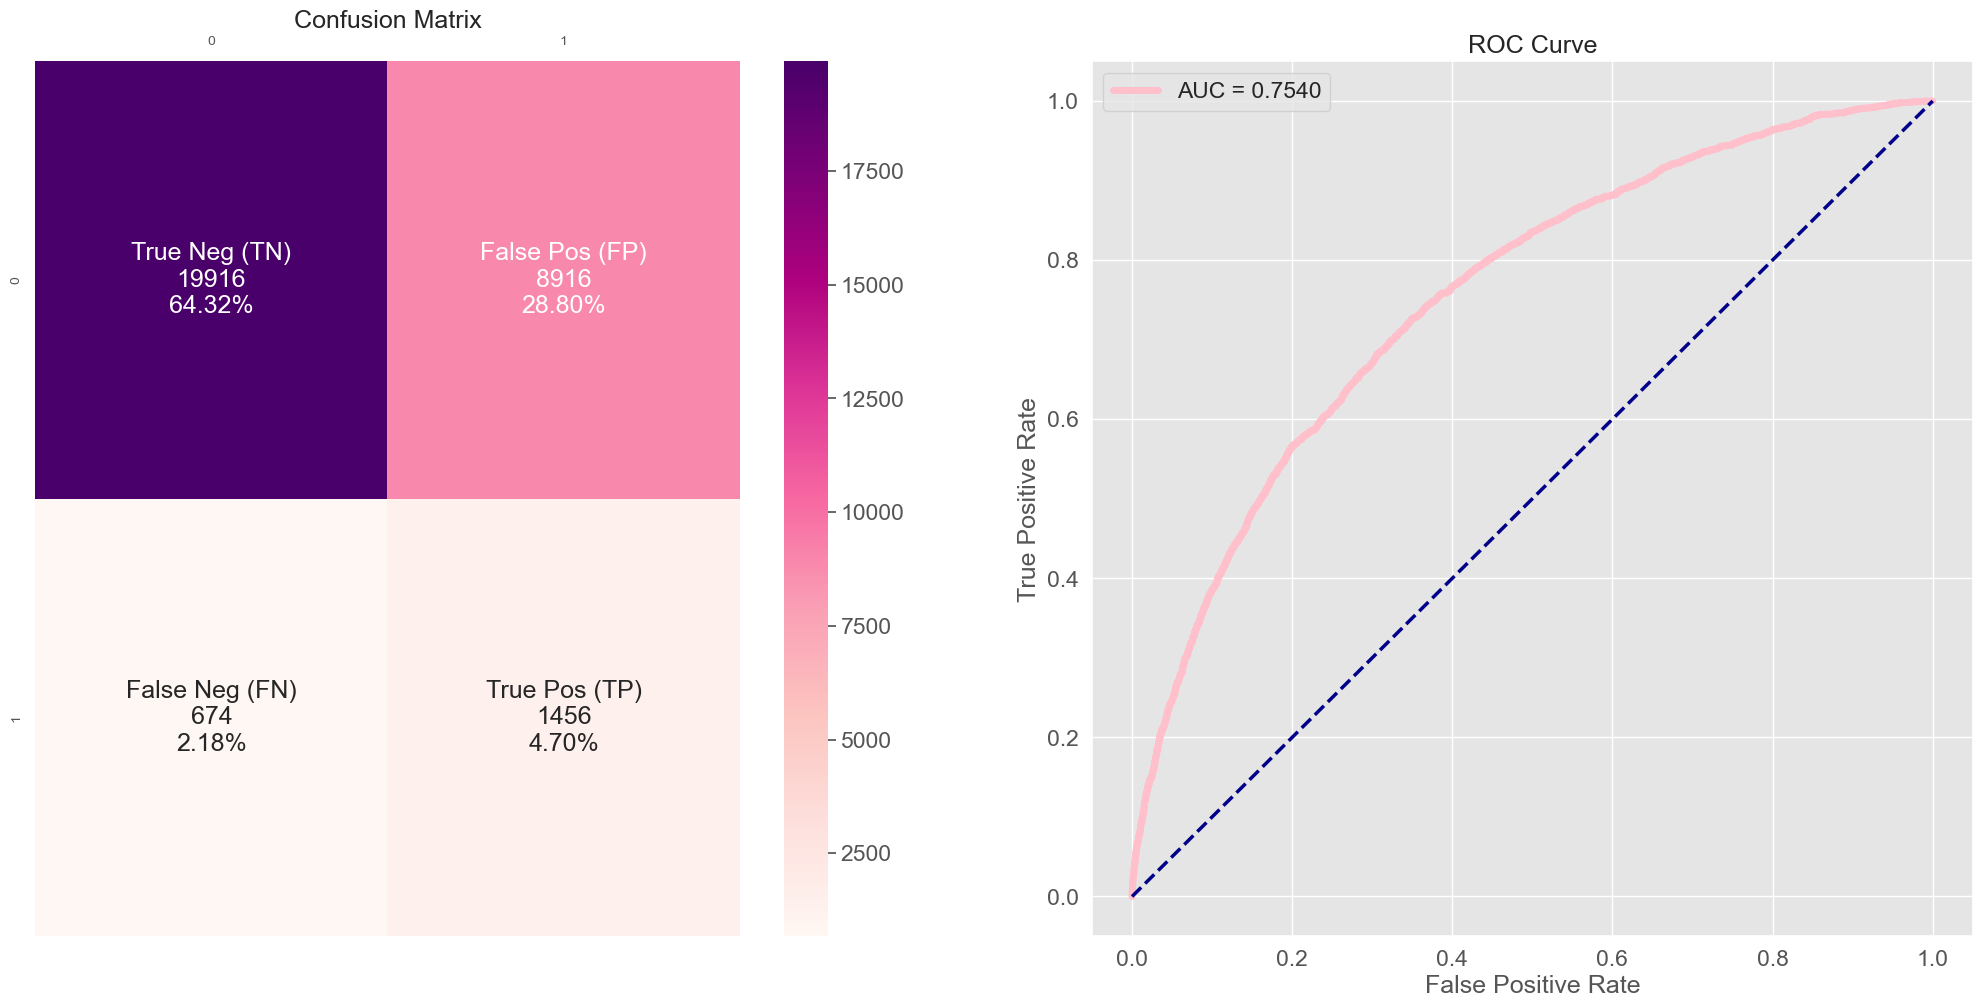

True negative =  19916
False positive =  8916
False negative =  674
True positive =  1456


In [188]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25), "matrice_roc_LGBM_under_best")

In [189]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6878706484178122

In [190]:
# Ajout des métriques du modèle 
comparison_thresh = pd.DataFrame(
        {
            "Modele": "Avant de déterminer le seuil optimal (0,50)",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[0],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle 
comparison_thresh 

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,"Avant de déterminer le seuil optimal (0,50)",0.690265,0.754021,0.683568,0.232923,1456,0.140378,674,0.687871,1.521157


In [191]:
# Création d'une séquence d'intervalles de seuils allant de 0 à 1 avec un pas de 0.01.
int_seuil = np.arange(0.0, 1.01, 0.01)

# Coefficients utilisés pour calculer le score en fonction des valeurs de faux positifs et faux négatifs.
coeff_fn = [-1000, -100, -10]

# Initialisation de listes pour stocker les scores en fonction des seuils pour chaque coefficient.
scor_int_1000 = []
scor_int_100 = []
scor_int_10 = []

# Regroupement des listes de scores dans une liste de listes.
scor_int = [scor_int_1000, scor_int_100, scor_int_10]

# Boucle pour calculer les scores en fonction des seuils et des coefficients.
for idx, lis in enumerate(scor_int):
    for s in int_seuil:
        # Initialisation d'une liste pour stocker les étiquettes de classe en fonction du seuil 's'.
        y_seuil = []
        # Conversion des probabilités de classe en étiquettes binaires (0 ou 1) en fonction du seuil 's'.
        for i in probability_default_payment:
            if i >= s:
                y_seuil.append(1)
            elif i < s:
                y_seuil.append(0)
        
        # Calcul de la matrice de confusion en comparant les étiquettes réelles 'y_test' avec les étiquettes binaires 'y_seuil'.
        tn, fp, fn, tp = confusion_matrix(y_test, y_seuil, labels=[0, 1]).ravel()

        # Calcul du score en utilisant la fonction 'score_banq' avec les valeurs de faux positifs, faux négatifs et les coefficients spécifiés.
        score = score_banq(tn, fp, fn, tp, 10, -1, coeff_fn[idx], 0)
        
        # Ajout du score calculé à la liste appropriée dans 'scor_int'.
        scor_int[idx].append(score)

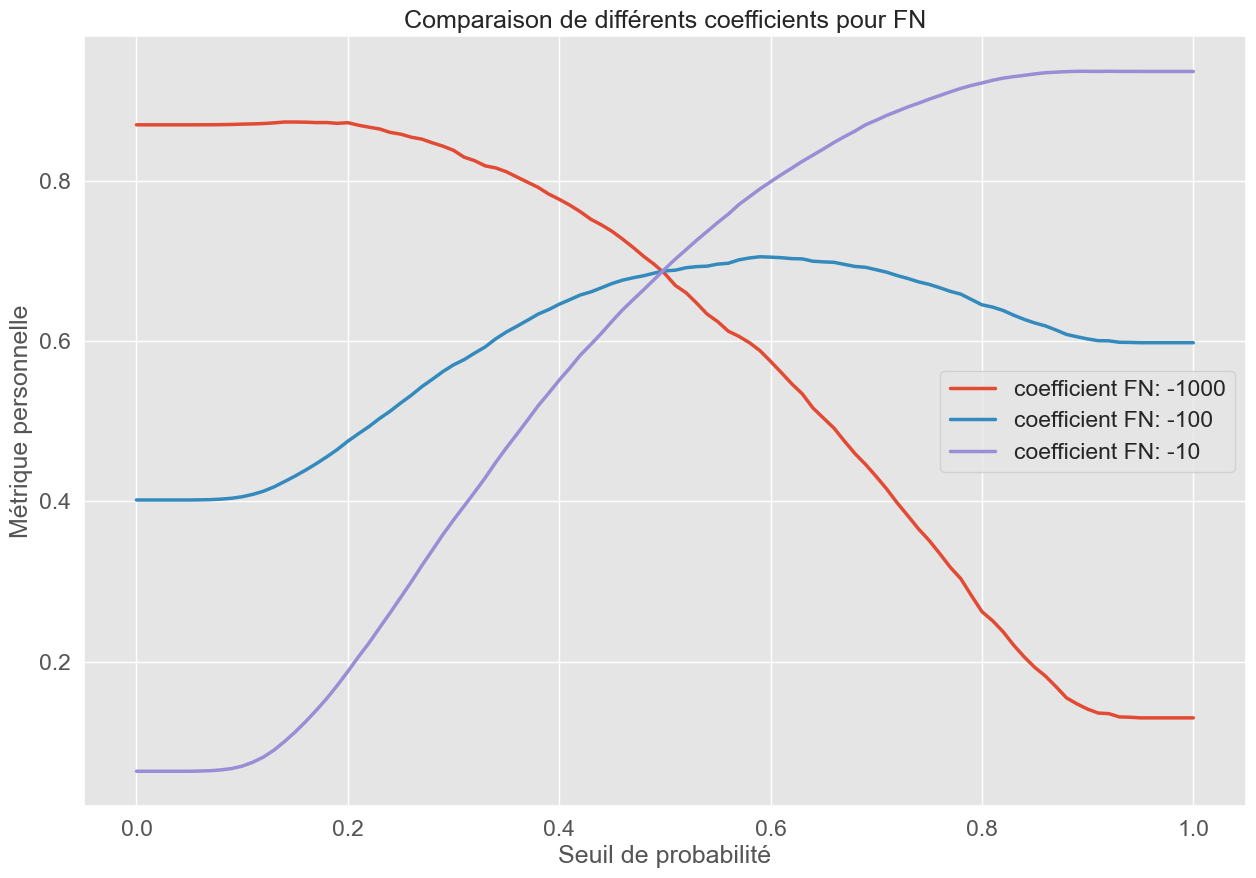

In [192]:
# Affichage du gain en fonction du seuil de solvabilité   

# Définition de la taille de la figure du graphique.
plt.figure(figsize=(15, 10))

# Tracé des courbes pour les scores en fonction des seuils pour chaque coefficient FN.
plt.plot(int_seuil, scor_int_1000, label="coefficient FN: -1000")
plt.plot(int_seuil, scor_int_100, label="coefficient FN: -100")
plt.plot(int_seuil, scor_int_10, label="coefficient FN: -10")

# Ajout d'étiquettes pour les axes x et y.
plt.xlabel("Seuil de probabilité")
plt.ylabel("Métrique personnelle")

# Titre du graphique.
plt.title('Comparaison de différents coefficients pour FN')

# Ajout de la légende pour identifier chaque courbe.
plt.legend()

# Affichage du graphique.
plt.show()

Ces courbes montrent que la métrique personnelle est pertinente pour notre problématique. Lorque l'on donne un coefficient de -1000 pour les FN, le seuil optimal pour que la banque ait le maximum de gain d'argent se situe aux alentours d'une probabilité de 0,2 à partir de laquelle on peut voir que la courbe des gains décroit rapidement. Ce coefficient est trop strict car seules les personnes avec une probabilité de défaut de paiement < 0,2% se voient accepter leur prêt ce qui correspond à peu de personnes.

Au contraire, lorsque l'on donne un coefficient de -10 pour les FN, on peut dire que la banque est trop laxiste dans le choix des clients pour l'accord d'un prêt car le seuil optimal pour que la banque ait le maximum de gain d'argent se situe aux alentours d'une probabilité de 0,9 et toutes les personnes avec une probabilité de défaut de paiement < 0,9% se verraient accepter leur prêt ce qui correspond à beaucoup de personnes.

Un coefficient de - 100 est mieux adapté car le seuil optimal se situerait aux alentours de 0,5 ce qui est correct pour déterminer si oui ou non le prêt est accepté.

#### Seuil optimal pour maximiser les gains de la banque

La métrique score_gain doit être maximisée pour que la banque gagne le plus d'argent et ainsi permettre de déterminer à partir de quel seuil de probabilité un client est considéré comme solvable ou non. Généralement le seuil de probabilité choisi par les modèles pour classer les individus est de 0,5 mais étant donné nos résultats, il ne s'agit pas du seuil optimal pour que la banque maximise ses gains.

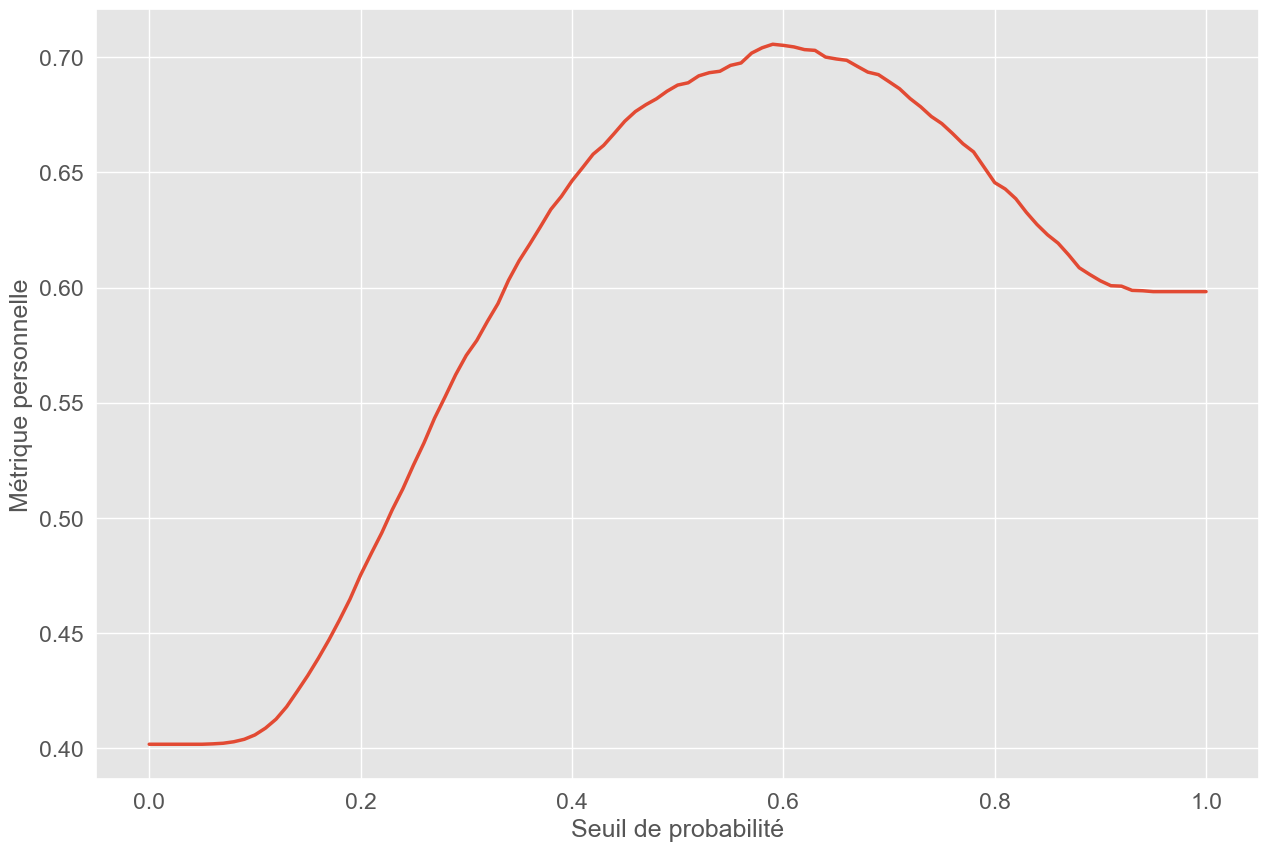

In [193]:
# Initialisation d'une liste vide pour stocker les scores pour la métrique personnalisée.
scor_int = []

# Création d'une liste de seuils de probabilité de 0.0 à 1.0 avec un pas de 0.01.
int_seuil = np.arange(0.0, 1.01, 0.01)

# Boucle pour calculer les scores pour chaque seuil de probabilité.
for s in int_seuil:
    # Initialisation d'une liste pour stocker les valeurs prédites en fonction du seuil.
    y_seuil = []

    # Boucle pour prédire les valeurs en fonction des probabilités et du seuil.
    for i in probability_default_payment:
        if i >= s:
            y_seuil.append(1)
        elif i < s:
            y_seuil.append(0)

    # Calcul de la matrice de confusion à partir des valeurs prédites et réelles.
    tn, fp, fn, tp = confusion_matrix(y_test, y_seuil, labels=[0, 1]).ravel()

    # Calcul du score pour la métrique personnalisée à l'aide de la fonction score_banq().
    scor_int.append(score_banq(tn, fp, fn, tp, 10, -1, -100, 0))

# Tracé du graphique pour visualiser les scores en fonction des seuils de probabilité.
plt.figure(figsize=(15, 10))
plt.plot(int_seuil, scor_int)
plt.xlabel("Seuil de probabilité")
plt.ylabel("Métrique personnelle")
plt.show()

In [195]:
import numpy as np

# Calcul de l'indice du maximum dans le tableau des scores
indice_max = np.argmax(scor_int)

# Obtention de la valeur du seuil de probabilité correspondant
seuil = int_seuil[indice_max]

# Obtention de la valeur du score au pic
score_max = scor_int[indice_max]

print(f"Le pic de la courbe se produit au seuil de probabilité {seuil} avec un score de {score_max}")

Le pic de la courbe se produit au seuil de probabilité 0.59 avec un score de 0.7055957536706454


C'est donc à partir de ce seuil optimal que la banque devrait décider d'accorder ou non un prêt pour avoir le maximum de gain.

In [196]:
# prédire la classe de chaque échantillon en fonction du seuil de probabilité optimal déterminé précédemment
prediction = []

# Parcours de chaque probabilité de défaut de paiement
for i in probability_default_payment:
    if i >= seuil:
        prediction.append(1)  # Si la probabilité est supérieure ou égale au seuil, prédiction de la classe 1 (défaut de paiement)
    elif i < seuil:
        prediction.append(0)  # Si la probabilité est inférieure au seuil, prédiction de la classe 0 (pas de défaut de paiement)

In [197]:
def test_train_col_category(dataframe_train, dataframe_test, col, size, seuil):
    '''la fonction prend en entrée deux DataFrames,
    le nom d'une colonne, une taille pour la figure et un seuil.
    La fonction calcule ensuite les valeurs 
    et les étiquettes de la colonne dans les ensembles d'entraînement 
    et de test, puis crée deux graphiques en camembert 
    pour comparer visuellement la distribution des valeurs de la colonne
    entre les deux ensembles, en tenant compte du seuil spécifié 
    pour le deuxième graphique.
    '''

    # Calculer les valeurs et les étiquettes de la colonne pour l'ensemble d'entraînement
    values_train = dataframe_train[col].value_counts()
    labels_train = dataframe_train[col].value_counts().index

    # Calculer les valeurs et les étiquettes de la colonne pour l'ensemble de test
    values_test = dataframe_test[col].value_counts()
    labels_test = dataframe_test[col].value_counts().index
    
    # Créer une nouvelle figure avec une taille spécifiée
    plt.figure(figsize=size)

    # Première sous-figure (1ère colonne de 2x2)
    plt.subplot(2, 2, 1)
    # Titre du graphique
    plt.title("Distribution of clients at threshold 0.50", fontsize=20)
    # Créer un graphique en camembert (pie chart) pour représenter la distribution des valeurs dans l'ensemble d'entraînement
    plt.pie(values_train, labels=labels_train, autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
    
    # Deuxième sous-figure (2ème colonne de 2x2)
    plt.subplot(2, 2, 2)
    # Titre du graphique
    plt.title("Distribution of clients at threshold {}".format(seuil), fontsize=20)
    # Créer un graphique en camembert (pie chart) pour représenter la distribution des valeurs dans l'ensemble de test avec le seuil spécifié
    plt.pie(values_test, labels=labels_test, autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
    # Ajuster l'aspect du graphique pour qu'il soit circulaire
    plt.axis('equal')
    plt.tight_layout()
    # Afficher la légende pour identifier les différentes catégories
    plt.legend()
    # Afficher les graphiques
    plt.show()

In [198]:
# Crée un DataFrame avec deux colonnes : "SK_ID_CURR" pour les identifiants des clients du jeu de test (X_test)
# et "probability_default_payment" pour stocker les prédictions binaires (0 ou 1) pour le défaut de paiement
predictive_class_54 = pd.DataFrame({
    'SK_ID_CURR': X_test.index, # La première colonne 'SK_ID_CURR' contiendra les identifiants uniques des emprunteurs dans l'ensemble de test.
    'probability_default_payment': prediction # La deuxième colonne 'probability_default_payment' contiendra les probabilités de défaut de paiement prédites par le modèle pour chaque emprunteur dans X_test.
    })

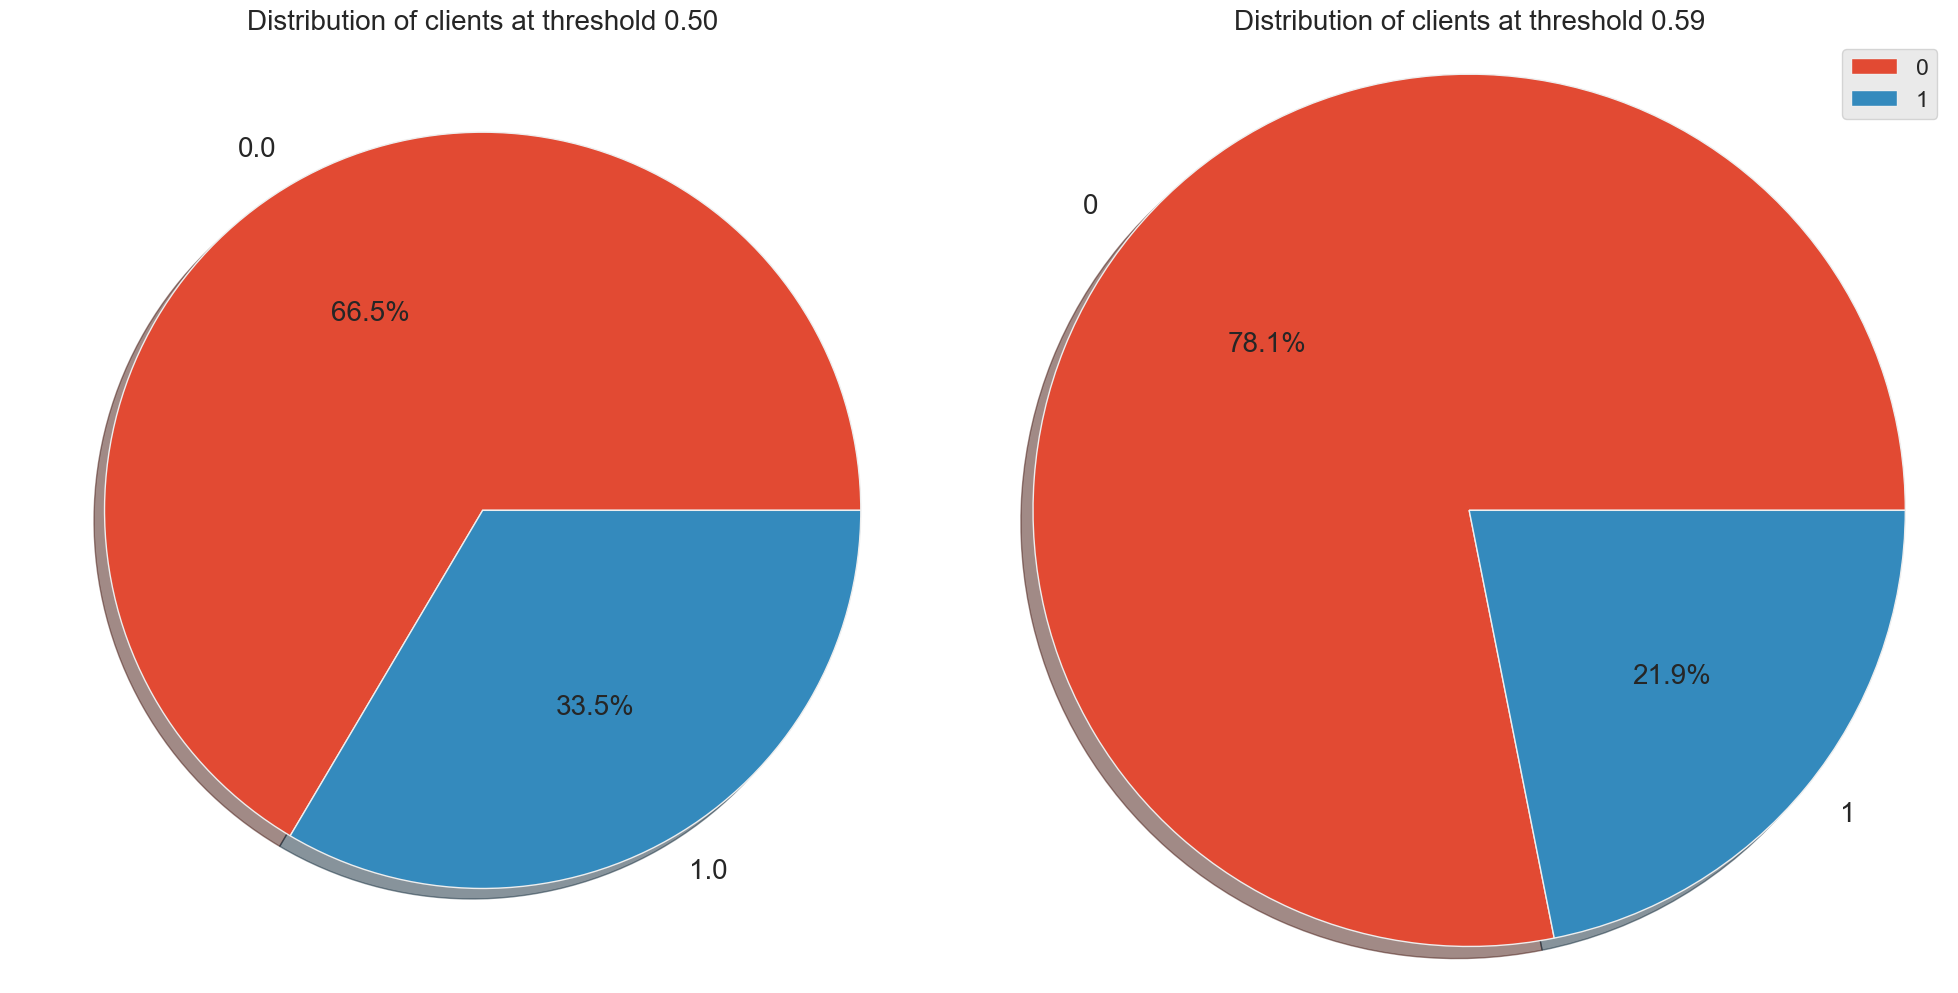

In [199]:
test_train_col_category(predictive_class_50, predictive_class_54, 'probability_default_payment', (20,20), seuil)

In [200]:
# Calcul de l'accuracy entre les vraies étiquettes (y_test) et les prédictions binaires du modèle (prediction)
accuracy = accuracy_score(y_test, prediction)
print(colored(f'L\'accuracy score est de {accuracy}\n', 'blue'))

# Calcul du score de précision entre les vraies étiquettes (y_test) et les prédictions binaires du modèle (prediction)
precision = precision_score(y_test, prediction, average='binary')
print(colored(f'Le score de précision est de {precision}\n', 'blue'))

# Calcul du score recall entre les vraies étiquettes (y_test) et les prédictions binaires du modèle (prediction)
recall = recall_score(y_test, prediction, average='binary')
print(colored(f'Le score recall est de {recall}\n', 'blue'))

# Calcul de l'AUC (Area Under the Curve) entre les vraies étiquettes (y_test) et les probabilités de défaut de paiement (probability_default_payment)
AUC = roc_auc_score(y_test, probability_default_payment)       
print(colored(f'Le score AUC est de {AUC} \n', 'blue'))

# Calcul du score f1 entre les vraies étiquettes (y_test) et les prédictions binaires du modèle (prediction)
f1 = f1_score(y_test, prediction, average='binary')
print(colored(f'Le score f1 est de {f1}\n', 'blue'))

L'accuracy score est de 0.7889348233318261

Le score de précision est de 0.1748117525468773

Le score recall est de 0.5558685446009389

Le score AUC est de 0.7540214999765519 

Le score f1 est de 0.265977760305515



In [201]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),23243 (TN),5589 (FP)
Real Positive (1),946 (FN),1184 (TP)


In [202]:
# Calcul de l'AUC (Area Under the Curve) en utilisant les étiquettes réelles 'y_test' et les probabilités de classe positive 'probability_default_payment'.
roc_auc = roc_auc_score(y_test, probability_default_payment)

# Affichage du résultat de l'AUC 
print('AUC : %0.4f' % roc_auc)

# Calcul du rapport de classification en comparant les étiquettes réelles 'y_test' et les prédictions 'prediction'.
# La fonction 'classification_report' produit un rapport complet incluant les métriques de précision, rappel, F1-score et le support pour chaque classe.
report = classification_report(y_test, prediction)

# Affichage du rapport de classification.
print(report)

AUC : 0.7540
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88     28832
         1.0       0.17      0.56      0.27      2130

    accuracy                           0.79     30962
   macro avg       0.57      0.68      0.57     30962
weighted avg       0.91      0.79      0.83     30962



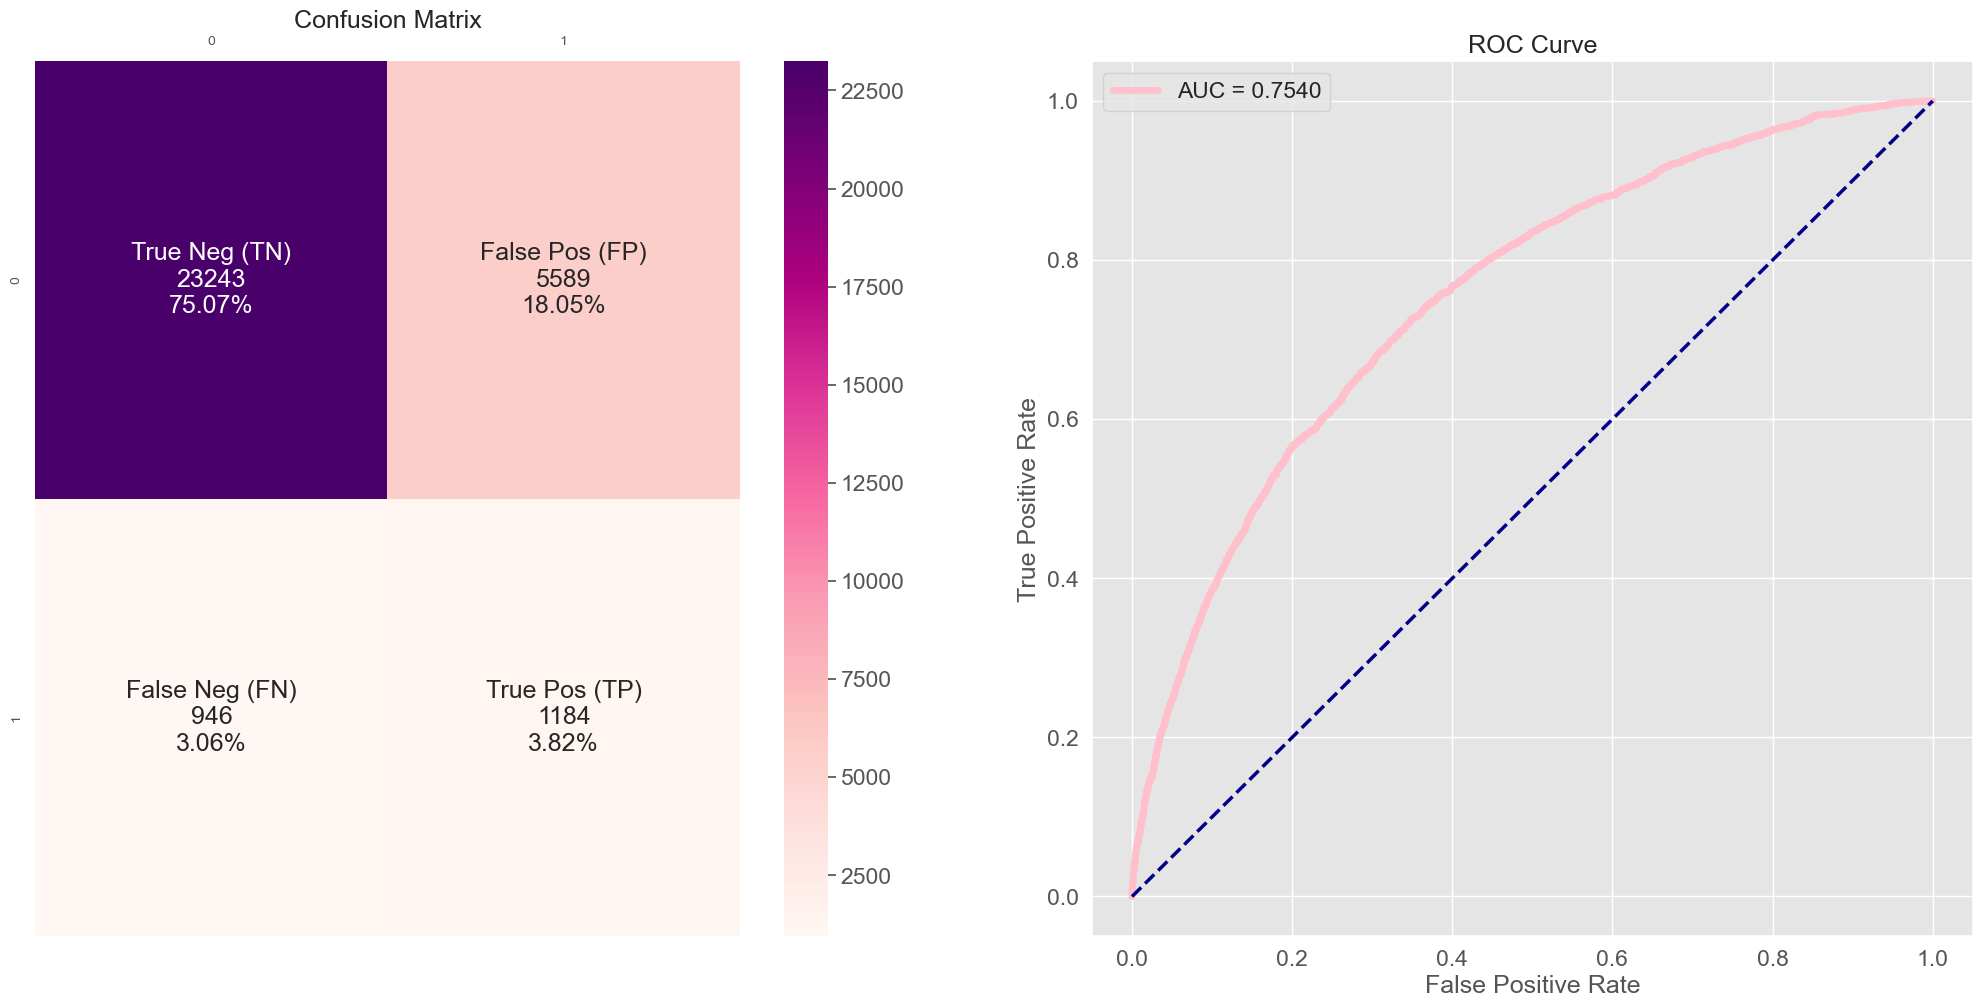

True negative =  23243
False positive =  5589
False negative =  946
True positive =  1184


In [203]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25), "matrice_under_LGBM_under_best.png")

In [204]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.7055957536706454

In [205]:
# Ajout des métriques du modèle 
comparison_thresh_59 = pd.DataFrame(
        {
            "Modele": "Après détermination du seuil optimal (0,59)",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[1],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle 
comparison_thresh = pd.concat([comparison_thresh,comparison_thresh_59])
comparison_thresh

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,"Avant de déterminer le seuil optimal (0,50)",0.690265,0.754021,0.683568,0.232923,1456,0.140378,674,0.687871,1.521157
1,"Après détermination du seuil optimal (0,59)",0.788935,0.754021,0.555869,0.265978,1184,0.174812,946,0.705596,1.521157


In [206]:
# Création d'un nouveau DataFrame en concaténant X_test et y_test le long de l'axe des colonnes (axis=1).
comparison_percentage = pd.concat([X_test, y_test], axis=1)

# Ajout d'une colonne appelée 'PREDICTION' au DataFrame "comparison_percentage" pour y stocker les prédictions du modèle "prediction".
comparison_percentage['PREDICTION'] = prediction

In [207]:
comparison_percentage

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,...,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business_Entity_Type_1,ORGANIZATION_TYPE_Business_Entity_Type_2,ORGANIZATION_TYPE_Business_Entity_Type_3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry_type_1,ORGANIZATION_TYPE_Industry_type_10,ORGANIZATION_TYPE_Industry_type_11,ORGANIZATION_TYPE_Industry_type_12,ORGANIZATION_TYPE_Industry_type_13,ORGANIZATION_TYPE_Industry_type_2,ORGANIZATION_TYPE_Industry_type_3,ORGANIZATION_TYPE_Industry_type_4,ORGANIZATION_TYPE_Industry_type_5,ORGANIZATION_TYPE_Industry_type_6,ORGANIZATION_TYPE_Industry_type_7,ORGANIZATION_TYPE_Industry_type_9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal_Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security_Ministries,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade_type_1,ORGANIZATION_TYPE_Trade_type_2,ORGANIZATION_TYPE_Trade_type_3,ORGANIZATION_TYPE_Trade_type_4,ORGANIZATION_TYPE_Trade_type_5,ORGANIZATION_TYPE_Trade_type_6,ORGANIZATION_TYPE_Trade_type_7,ORGANIZATION_TYPE_Transport_type_1,ORGANIZATION_TYPE_Transport_type_2,ORGANIZATION_TYPE_Transport_type_3,ORGANIZATION_TYPE_Transport_type_4,ORGANIZATION_TYPE_University,HOUSETYPE_MODE_block_of_flats,HOUSETYPE_MODE_specific_housing,HOUSETYPE_MODE_terraced_house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stone_brick,WALLSMATERIAL_MODE_Wooden,MOST_CREDIT_TYPE_Another_type_of_loan,MOST_CREDIT_TYPE_Car_loan,MOST_CREDIT_TYPE_Consumer_credit,MOST_CREDIT_TYPE_Credit_card,MOST_CREDIT_TYPE_Loan_for_business_development,MOST_CREDIT_TYPE_Loan_for_working_capital_replenishment,MOST_CREDIT_TYPE_Microloan,MOST_CREDIT_TYPE_Mortgage,TARGET,PREDICTION
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
316145,0,0,0,1,0,-0.573222,0.140349,-0.271295,-0.365874,-0.276938,0.181777,1.228470,0.620128,-1.477886,-0.799974,0.002542,-2.182687,-0.46321,0.047807,-0.671139,-0.267116,-0.108965,0.032789,0.100683,-0.090535,-0.110786,-0.220085,-

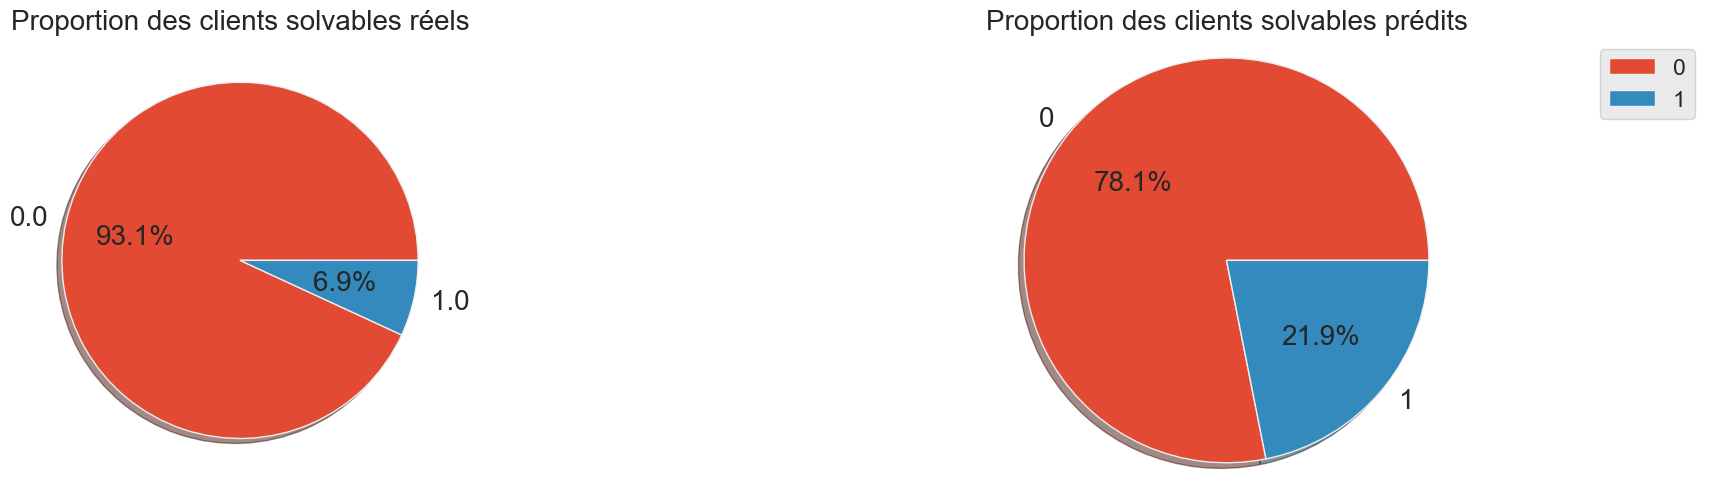

In [208]:
# Compter le nombre de clients solvables (0) et de clients insolvable (1) dans les données réelles (y_test) et stocker les valeurs et les étiquettes.
values_train = comparison_percentage["TARGET"].value_counts()
labels_train = comparison_percentage["TARGET"].value_counts().index

# Compter le nombre de clients solvables (0) et de clients insolvable (1) dans les prédictions du modèle (prediction) et stocker les valeurs et les étiquettes.
values_test = comparison_percentage["PREDICTION"].value_counts()
labels_test = comparison_percentage["PREDICTION"].value_counts().index
    
# Créer une figure de taille (20, 10) pour afficher les deux graphiques côte à côte.
plt.figure(figsize=(20,10))
    
# Sous-plot 1: Afficher un graphique circulaire (pie chart) de la proportion des clients solvables dans les données réelles.
plt.subplot(2, 2, 1)
plt.title("Proportion des clients solvables réels", fontsize=20)
plt.pie(values_train, labels=labels_train, autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
    
# Sous-plot 2: Afficher un graphique circulaire (pie chart) de la proportion des clients solvables prédits par le modèle.
plt.subplot(2, 2, 2)
plt.title("Proportion des clients solvables prédits", fontsize=20)
plt.pie(values_test, labels=labels_test, autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
plt.axis('equal')  # Pour que le graphique soit un cercle complet (un aspect équilibré).
plt.tight_layout()  # Pour éviter que les labels se chevauchent.
plt.legend()  # Ajouter une légende pour indiquer la signification des couleurs.
plt.show()  # Afficher les deux graphiques.

#### Importance des features

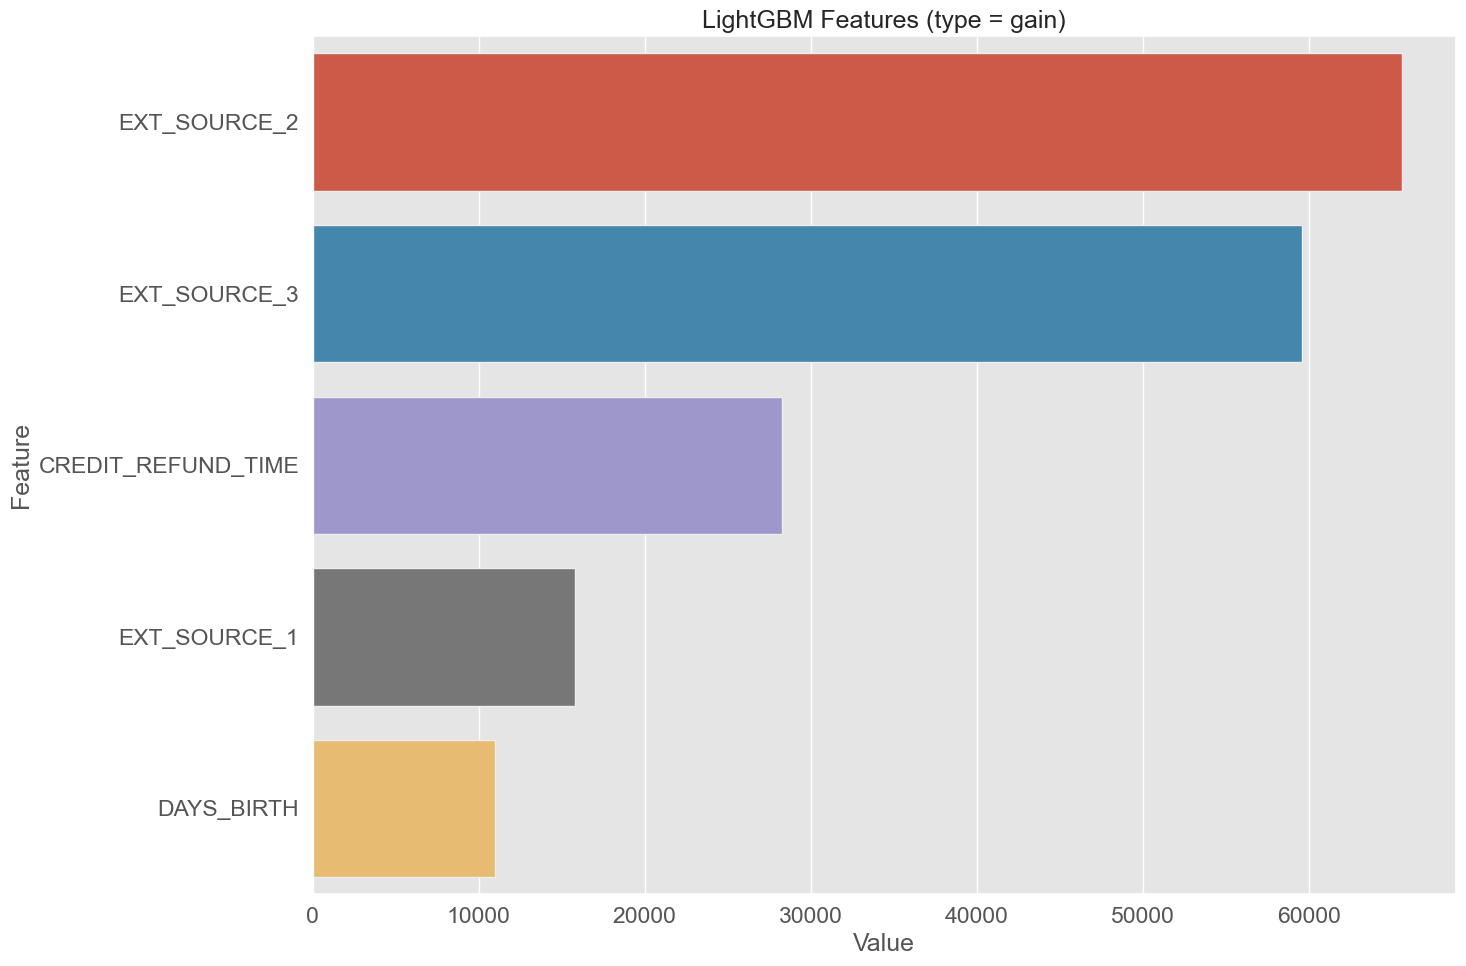

In [209]:
# Calculer l'importance des fonctionnalités en utilisant les gains (type='gain') du modèle LightGBM.
feature_imp = pd.DataFrame(sorted(zip(best_model.booster_.feature_importance(importance_type='gain'), X_train_under.columns)), columns=['Value', 'Feature'])

# Créer une figure pour afficher le graphique des fonctionnalités les plus importantes.
plt.figure(figsize=(15, 10))

# Tracer un graphique à barres (barplot) pour afficher les 5 fonctionnalités les plus importantes.
# Les fonctionnalités sont triées par ordre décroissant en fonction de leurs valeurs d'importance (gains).
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(5))

# Ajouter un titre au graphique.
plt.title('LightGBM Features (type = gain)')

# Ajuster la disposition du graphique pour qu'il soit bien affiché.
plt.tight_layout()

# Afficher le graphique des fonctionnalités les plus importantes.
plt.show()

A priori, les features les plus importantes pour la prédiction d'accord d'un prêt sont les variables EXT_SOURCE_3 et 2 qui sont les scores normalisés créés à partir d'une source de données externe. Ces scores pourraient regrouper différentes caractéristiques sur le paiement d'un crédit comme le retard de paiement. Ainsi, plus ces scores sont élevés et plus la demande de prêt du client risque d'être refusée. Ensuite, on a la feature PAYMENT_RATE qui correspond à la durée que met un client à rembourser un prêt. Plus le temps de remboursement des crédits est grand plus il y a de chance que le prêt ne lui soit pas accordé. Puis la feature DAYS_BIRTH qui est le nombre de jours depuis la naissance des clients ce qui signifie que l'age des clients joue un rôle important dans l'acceptation du crédit. Pour rappel, plus le client est jeune, plus il aura du mal à rembourser son prêt.

#### Features importance avec SHAP (SHapley Additive exPlanations) 

Les valeurs de Shapley calculent l’importance d’une variable en comparant la sortie qu’un modèle peut prédire avec et sans cette variable avec toutes les combinaisons de variables possibles afin que les fonctionnalités soient comparées équitablement. La somme des effets de chaque variable expliquera la prédiction.

Les valeurs Shap sont des tableaux d'une longueur correspondant au nombre de classes dans la cible. Ici, le problème est la classification binaire, et donc les valeurs Shap ont deux tableaux correspondant à l'une ou l'autre classe.

Les valeurs Shap sont des nombres à virgule flottante correspondant aux données de chaque ligne correspondant à chaque caractéristique. La valeur Shap représente la contribution de ce point de données particulier dans la prédiction des sorties. Si la valeur shap est très proche de zéro, on peut dire que le point de données contribue très peu aux prédictions. Si la valeur shap est une valeur fortement positive ou fortement négative, nous pouvons dire que le point de données contribue grandement à la prédiction de la classe positive ou négative.

#### Interprétabilité globale

pip install shap

In [211]:
import shap
# Calculer les valeurs SHAP pour les prédictions du modèle LightGBM.
# On utilise le TreeExplainer de SHAP en lui passant le modèle LightGBM (best_model.booster_) pour expliquer les prédictions.
# X_test.iloc[:10000,:] : Sous-ensemble des données de test pour lesquelles nous voulons calculer les valeurs SHAP.
shap_values = shap.TreeExplainer(best_model.booster_).shap_values(X_test.iloc[:10000, :])

In [ ]:
shap_values = shap.TreeExplainer(best_model.booster_).shap_values(X_test.iloc[:10000, :])
global_importances = np.abs(shap_values).mean(0)[:-1]
st.bar_chart(global_importances[:-1])

In [212]:
# Calculer l'importance globale des features à partir des valeurs SHAP.
# np.abs(shap_values) prend la valeur absolue des SHAP values pour chaque feature et chaque prédiction.
# .mean(0) calcule la moyenne des SHAP values pour chaque feature sur l'ensemble des prédictions.
# [:-1] est utilisé pour exclure la dernière colonne qui correspond à la colonne de biais ou d'intercept du modèle (non une feature réelle).
global_importances = np.abs(shap_values).mean(0)[:-1]

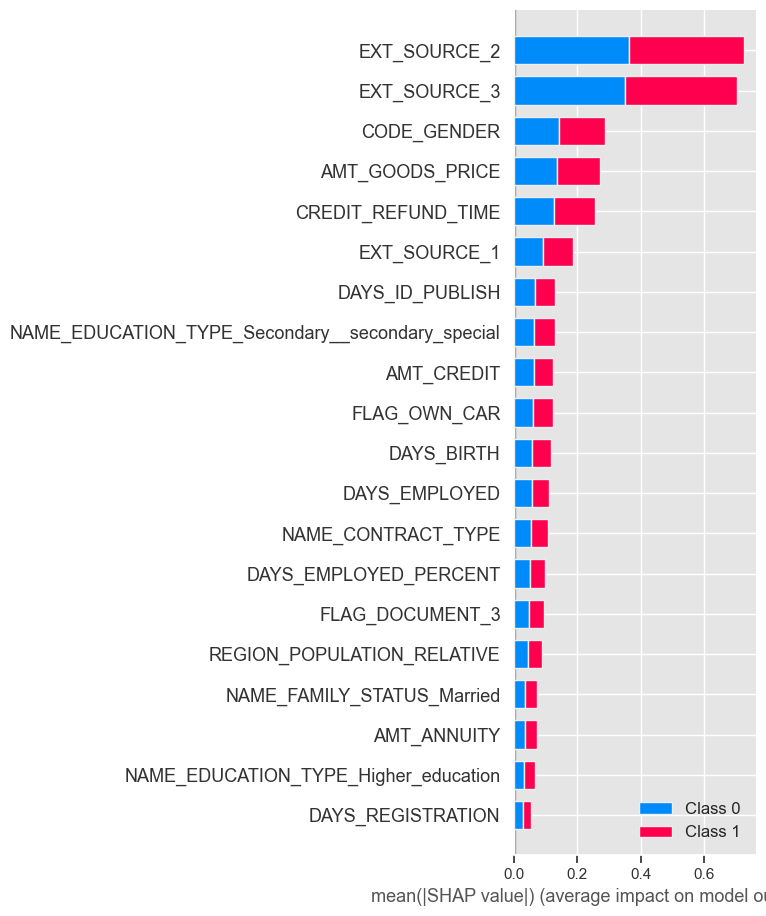

In [213]:
# shap.summary_plot(shap_values, X_test.iloc[:10000,:]) génère un graphique de résumé.
# shap_values est la matrice des valeurs SHAP calculées précédemment pour les prédictions du modèle sur les 10 000 premières lignes de X_test.
# X_test.iloc[:10000,:] sélectionne les 10 000 premières lignes du DataFrame X_test pour lesquelles nous voulons afficher les explications.
# Le graphique de résumé affiche une barre horizontale pour chaque feature, indiquant son impact sur les prédictions.
# Les features sont triées par importance globale, de la plus à la moins importante.
# La couleur des barres représente la valeur de la feature pour chaque prédiction, où le bleu indique des valeurs basses et le rouge des valeurs élevées.
# Le graphique permet de visualiser comment chaque feature contribue aux prédictions du modèle et dans quelle mesure.
shap.summary_plot(shap_values, X_test.iloc[:10000,:])

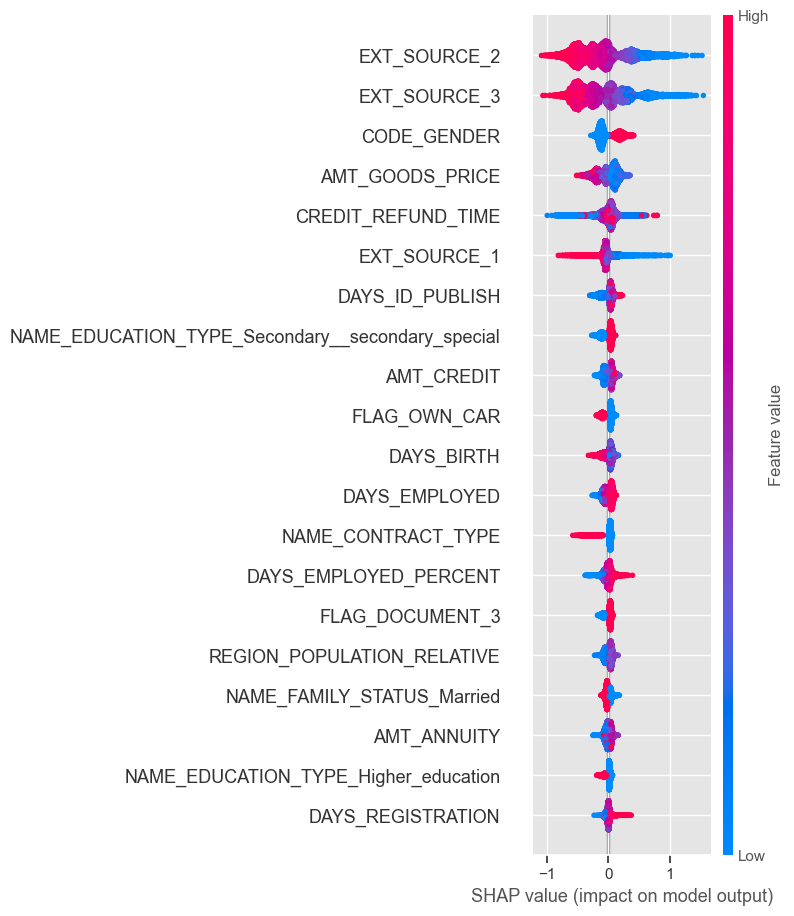

In [214]:
# shap.summary_plot(shap_values[1], X_test.astype("float").iloc[:10000,:]) génère un graphique de résumé spécifique à la classe "1".
# shap_values[1] correspond aux valeurs SHAP calculées précédemment pour les prédictions de la classe "1" du modèle sur les 10 000 premières lignes de X_test.
# X_test.astype("float").iloc[:10000,:] sélectionne les 10 000 premières lignes du DataFrame X_test et les convertit en type "float".
# Le graphique de résumé spécifique à la classe "1" affiche une barre horizontale pour chaque feature, indiquant son impact sur les prédictions de la classe "1".
# Les features sont triées par importance globale, de la plus à la moins importante, pour la classe "1".
# La couleur des barres représente la valeur de la feature pour chaque prédiction de la classe "1", où le bleu indique des valeurs basses et le rouge des valeurs élevées.
# Le graphique permet de visualiser comment chaque feature contribue spécifiquement aux prédictions de la classe "1" du modèle et dans quelle mesure.
shap.summary_plot(shap_values[1], X_test.astype("float").iloc[:10000,:])

Ces graphes ont permis de générer un résumé de l'importance des features en utilisant les valeurs SHAP visant donc à  montrer comment chaque caractéristique contribue aux prédictions de notre modèle. Pour rappel, dans notre projet, la prédiction correspond à la probabilité qu'un emprunteur soit en défaut de crédit.
L'axe horizontal permet de quantifier l'importance relative de chaque caractéristique pour une prédiction donnée. On peut identifier les caractéristiques qui contribuent le plus positivement ou négativement à la prédiction en fonction de leur position sur l'axe horizontal. Plus la valeur absolue de l'effet SHAP est élevée, plus la caractéristique a un impact important sur la prédiction.

On retrouve les variables EXT_SOURCE 2 et 3 ainsi que CODE_GENDER en tête. Un peu plus bas on a la variable DAYS_BIRTHS même si elle semble jouer un rôle moins important pour le fait qu'une personne soit non solvable. 
Avec cette représentation, le genre du client est important dans la prédiction mais on nous n'allons pas en tenir compte pour éviter toute discrimination. La variable AMT_GOODS_PRICE est dans le top des features importantes et elle correspond au montant du prix des biens pour lesquels le prêt est accordé pour les prêts de consommation qui ne sera pas pris en compte car le choix peut être biaisé et le crédit pourrait ne pas être accordé si le prix du bien est trop élevé.

#### Interprétabilité locale, exemple avec un client

Il est important d’avoir une compréhension globale du comportement du modèle sur l'ensemble des données, pour avoir une idée générale de la façon dont le modèle fonctionne, grâce à l’identification des features les plus importantes, les métriques utilisées précédemment (AUC/ROC), la visualisation des données. 

Mais il faut également avoir interprétabilité locale c’est-à-dire que l’on essaie de comprendre les décisions spécifiques du modèle sur des cas particuliers. Ceci va permettre d'expliquer pourquoi notre modèle a pris une décision particulière pour une observation donnée. 

In [235]:
X_test.iloc[idx,:]

NAME_CONTRACT_TYPE                                         0.0
CODE_GENDER                                                0.0
FLAG_OWN_CAR                                               0.0
FLAG_OWN_REALTY                                            1.0
EMERGENCYSTATE_MODE                                        0.0
                                                          ... 
MOST_CREDIT_TYPE_Credit_card                               0.0
MOST_CREDIT_TYPE_Loan_for_business_development             0.0
MOST_CREDIT_TYPE_Loan_for_working_capital_replenishment    0.0
MOST_CREDIT_TYPE_Microloan                                 0.0
MOST_CREDIT_TYPE_Mortgage                                  0.0
Name: 376840, Length: 209, dtype: float64

In [226]:
explainer_shap = shap.TreeExplainer(best_model)
shap_values = explainer_shap.shap_values(X_test)

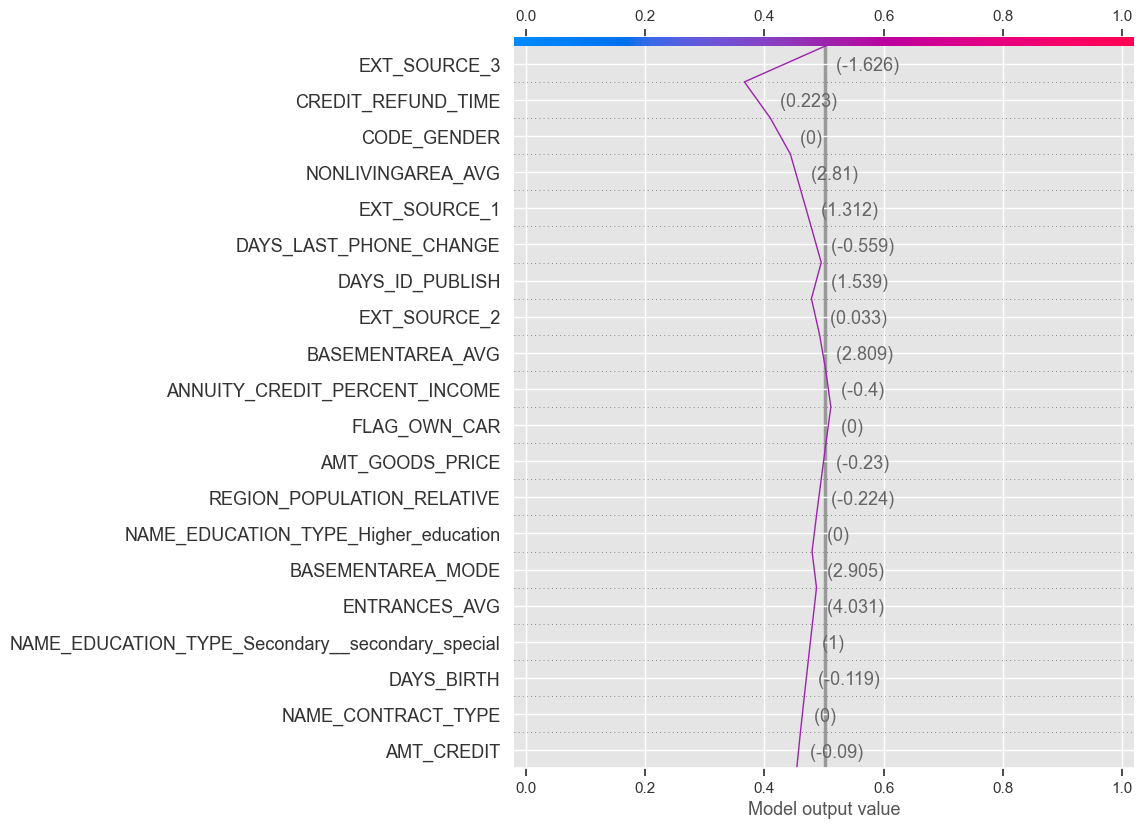

In [227]:
shap.decision_plot(explainer_shap.expected_value[1], 
                   shap_values[1][idx,:], 
                   X_test.iloc[idx,:], 
                   feature_names=X_test.columns.to_list(),
                   feature_order='importance',
                   #feature_display_range=slice(None, -15, -1),
                   link='logit')

Ce graphe montre donc comment chaque caractéristique contribue à la prédiction du modèle pour cette observation spécifique. Il permet de visualiser comment chaque caractéristique pousse la prédiction vers classe des clients qui ont défaut de crédit, c'est-à-dire ceux qui ne remboursent pas leur prêt ou qui ont des retards de paiement importants, ou vers la classe des clients qui ne présentent pas de défaut de crédit et donc qui remboursent correctement leurs prêts sans aucun problème de retard ou de défaut de paiement. Cela aide à comprendre l'impact des caractéristiques sur la prédiction du modèle pour une observation particulière.

Ces valeurs indiquent à quel point chaque caractéristique a contribué à la prédiction du modèle pour cette observation spécifique. Une valeur SHAP positive indique une contribution positive à la prédiction de la "classe positive" (c'est-à-dire un défaut de crédit), tandis qu'une valeur négative indique une contribution négative à cette prédiction, c'est-à-dire une probabilité moindre de défaut de crédit.

# Définissez le pourcentage d'échantillonnage (par exemple, 50%)
sample_percent = 0.5

# Sélectionnez un échantillon aléatoire de vos données d'entraînement
random_indices = np.random.choice(x_train.index, int(len(x_train) * sample_percent), replace=False)
X_train_sampled = x_train.loc[random_indices]
y_train_sampled = y_train.loc[random_indices]

# Appliquez SMOTE sur l'échantillon réduit
sm = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_sampled, y_train_sampled)

# Conversion des données suréchantillonnage en DataFrame pandas
# Cela permet de garder les noms de colonnes de X_train pour faciliter l'utilisation ultérieure
X_train_resampled = pd.DataFrame(X_train_resampled, columns=x_train.columns)